# Evaluating KANs vs MLPs for MNIST Classification in FL

This notebook is based mainly on the Flower Tutorial "Use a federated learning strategy", found in https://flower.ai/docs/framework/tutorial-series-use-a-federated-learning-strategy-pytorch.html .

## Global Values

In [ ]:
NUM_PARTITIONS = 100
BATCH_SIZE = 64
LOCAL_EPOCHS = 5
FRACTION_CLIENTS = 0.1
COMM_ROUNDS = 100
NET_TYPE = "kan"
LEARNING_RATE = 0.1
MOMENTUM = 0.9
HISTORY = {}
TRY_DEVICE = "cuda" # 'cuda' for gpu
SEED = 249

## Dependencies

In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.3/242.3 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.2/703.2 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 8.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is th

In [ ]:
# Efficient KAN
!pip install -q git+https://github.com/Blealtan/efficient-kan.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q git+https://github.com/ZiyaoLi/fast-kan.git

  Preparing metadata (setup.py) ... done


In [ ]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import random
import os
import re
import json
from logging import INFO

from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents, SimpleClientManager
from flwr.server.strategy import FedAvg, FedAdagrad
from flwr.simulation import run_simulation, start_simulation
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import PathologicalPartitioner, NaturalIdPartitioner
from flwr_datasets.visualization import plot_label_distributions
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context, Metrics
from flwr.common.logger import log
from flwr.server.client_proxy import ClientProxy
from flwr.server.criterion import Criterion
from flwr_datasets.preprocessor import Divider

# from efficient_kan import KAN
# from fastkan import FastKAN

DEVICE = torch.device(TRY_DEVICE)  # "cpu" or "cuda" ("mps" for Apple Silicon)
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")

Training on cuda
Flower 1.22.0 / PyTorch 2.8.0+cu126


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


##Efficient KAN classes

In [ ]:
class PureKANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(PureKANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        # construct the grid
        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        # spline weights
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 0.5
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                torch.nn.init.constant_(self.spline_scaler, self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        # PURE spline output (no base/linear part)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )

        output = spline_output.reshape(*original_shape[:-1], self.out_features)
        return output


class PureKAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_spline=1.0,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(PureKAN, self).__init__()

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                PureKANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_spline=scale_spline,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x


##RBF KAN Classes

In [ ]:
# Copyright 2024 Li, Ziyao
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import *

class SplineLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

class RadialBasisFunction(nn.Module):
    def __init__(
        self,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        denominator: float = None,  # larger denominators lead to smoother basis
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        use_layernorm: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layernorm = None
        if use_layernorm:
            assert input_dim > 1, "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = nn.LayerNorm(input_dim)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, spline_weight_init_scale)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = nn.Linear(input_dim, output_dim)

    def forward(self, x, use_layernorm=True):
        if self.layernorm is not None and use_layernorm:
            spline_basis = self.rbf(self.layernorm(x))
        else:
            spline_basis = self.rbf(x)
        ret = self.spline_linear(spline_basis.view(*spline_basis.shape[:-2], -1))
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret

    def plot_curve(
        self,
        input_index: int,
        output_index: int,
        num_pts: int = 1000,
        num_extrapolate_bins: int = 2
    ):
        '''this function returns the learned curves in a FastKANLayer.
        input_index: the selected index of the input, in [0, input_dim) .
        output_index: the selected index of the output, in [0, output_dim) .
        num_pts: num of points sampled for the curve.
        num_extrapolate_bins (N_e): num of bins extrapolating from the given grids. The curve
            will be calculate in the range of [grid_min - h * N_e, grid_max + h * N_e].
        '''
        ng = self.rbf.num_grids
        h = self.rbf.denominator
        assert input_index < self.input_dim
        assert output_index < self.output_dim
        w = self.spline_linear.weight[
            output_index, input_index * ng : (input_index + 1) * ng
        ]   # num_grids,
        x = torch.linspace(
            self.rbf.grid_min - num_extrapolate_bins * h,
            self.rbf.grid_max + num_extrapolate_bins * h,
            num_pts
        )   # num_pts, num_grids
        with torch.no_grad():
            y = (w * self.rbf(x.to(w.dtype))).sum(-1)
        return x, y


class FastKAN(nn.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.layers = nn.ModuleList([
            FastKANLayer(
                in_dim, out_dim,
                grid_min=grid_min,
                grid_max=grid_max,
                num_grids=num_grids,
                use_base_update=use_base_update,
                base_activation=base_activation,
                spline_weight_init_scale=spline_weight_init_scale,
            ) for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class AttentionWithFastKANTransform(nn.Module):

    def __init__(
        self,
        q_dim: int,
        k_dim: int,
        v_dim: int,
        head_dim: int,
        num_heads: int,
        gating: bool = True,
    ):
        super(AttentionWithFastKANTransform, self).__init__()

        self.num_heads = num_heads
        total_dim = head_dim * self.num_heads
        self.gating = gating
        self.linear_q = FastKANLayer(q_dim, total_dim)
        self.linear_k = FastKANLayer(k_dim, total_dim)
        self.linear_v = FastKANLayer(v_dim, total_dim)
        self.linear_o = FastKANLayer(total_dim, q_dim)
        self.linear_g = None
        if self.gating:
            self.linear_g = FastKANLayer(q_dim, total_dim)
        # precompute the 1/sqrt(head_dim)
        self.norm = head_dim**-0.5

    def forward(
        self,
        q: torch.Tensor,
        k: torch.Tensor,
        v: torch.Tensor,
        bias: torch.Tensor = None,      # additive attention bias
    ) -> torch.Tensor:

        wq = self.linear_q(q).view(*q.shape[:-1], 1, self.num_heads, -1) * self.norm     # *q1hc
        wk = self.linear_k(k).view(*k.shape[:-2], 1, k.shape[-2], self.num_heads, -1)    # *1khc
        att = (wq * wk).sum(-1).softmax(-2)     # *qkh
        del wq, wk
        if bias is not None:
            att = att + bias[..., None]

        wv = self.linear_v(v).view(*v.shape[:-2],1, v.shape[-2], self.num_heads, -1)     # *1khc
        o = (att[..., None] * wv).sum(-3)        # *qhc
        del att, wv

        o = o.view(*o.shape[:-2], -1)           # *q(hc)

        if self.linear_g is not None:
            # gating, use raw query input
            g = self.linear_g(q)
            o = torch.sigmoid(g) * o

        # merge heads
        o = self.linear_o(o)
        return o


## Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Configuring Seeds

In [ ]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
# torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True

## Kaggle Dataset Loading

In [ ]:
from google.colab import files
files.upload()  # Upload the `kaggle.json` file here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chirantha210613u","key":"4d00eab596a2e3cd94dc70515d0fe15a"}'}

In [ ]:
import os
import zipfile

# Make a directory and move kaggle.json there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -q kaggle

In [ ]:
# Replace this with the actual dataset name
!kaggle datasets download -d danialsharifrazi/cad-cardiac-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/danialsharifrazi/cad-cardiac-mri-dataset
License(s): unknown
 99% 2.82G/2.86G [00:31<00:00, 222MB/s]
100% 2.86G/2.86G [00:31<00:00, 97.9MB/s]


In [ ]:
!unzip cad-cardiac-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Sick/Directory_26/SR_57/IM00059.jpg  
  inflating: Sick/Directory_26/SR_57/IM00060.jpg  
  inflating: Sick/Directory_26/SR_58/IM00001.jpg  
  inflating: Sick/Directory_26/SR_58/IM00002.jpg  
  inflating: Sick/Directory_26/SR_58/IM00003.jpg  
  inflating: Sick/Directory_26/SR_58/IM00004.jpg  
  inflating: Sick/Directory_26/SR_58/IM00005.jpg  
  inflating: Sick/Directory_26/SR_58/IM00006.jpg  
  inflating: Sick/Directory_26/SR_58/IM00007.jpg  
  inflating: Sick/Directory_26/SR_58/IM00008.jpg  
  inflating: Sick/Directory_26/SR_58/IM00009.jpg  
  inflating: Sick/Directory_26/SR_58/IM00010.jpg  
  inflating: Sick/Directory_26/SR_58/IM00011.jpg  
  inflating: Sick/Directory_26/SR_58/IM00012.jpg  
  inflating: Sick/Directory_26/SR_58/IM00013.jpg  
  inflating: Sick/Directory_26/SR_59/IM00001.jpg  
  inflating: Sick/Directory_26/SR_59/IM00002.jpg  
  inflating: Sick/Directory_26/SR_59/IM00003.jpg  
  inflating: Sick/Directory_26/

In [ ]:
import os
from glob import glob

# Assuming you're in the Colab default directory after unzipping
base_path = '/content/Sick'  # This is the default directory in Colab

# Recursively search for all .jpg images
image_paths = glob(os.path.join(base_path, '**', '*.jpg'), recursive=True)

# Optional: sort the image list
image_paths.sort()

In [ ]:
# Root directories
normal_root = '/content/Normal'
sick_root = '/content/Sick'

# Get all .jpg files recursively
normal_images = glob(os.path.join(normal_root, '**', '*.jpg'), recursive=True)
sick_images = glob(os.path.join(sick_root, '**', '*.jpg'), recursive=True)

# Combine and label
all_images = normal_images + sick_images
labels = [0] * len(normal_images) + [1] * len(sick_images)

print(f'Total Normal images: {len(normal_images)}')
print(f'Total Sick images: {len(sick_images)}')

Total Normal images: 37564
Total Sick images: 25861


## Data loading

In [ ]:
import os
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [ ]:
from torch.utils.data import Subset

def partition_dataset(image_paths, labels, num_partitions):
    partitions = [[] for _ in range(num_partitions)]
    label_partitions = [[] for _ in range(num_partitions)]

    for i, (path, label) in enumerate(zip(image_paths, labels)):
        partitions[i % num_partitions].append(path)
        label_partitions[i % num_partitions].append(label)

    return list(zip(partitions, label_partitions))


In [ ]:
class MRIDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('L')  # Use 'RGB' if your images are in color

        if self.transform:
            image = self.transform(image)

        return {"image": image, "label": label}

In [ ]:
def load_datasets(partition_id: int, num_partitions: int = 5):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    partitioned_data = partition_dataset(all_images, labels, num_partitions)

    image_paths_partition, labels_partition = partitioned_data[partition_id]

    train_paths, val_paths, train_labels, val_labels = train_test_split(
        image_paths_partition, labels_partition, test_size=0.2, stratify=labels_partition, random_state=42
    )

    train_dataset = MRIDataset(train_paths, train_labels, transform=transform)
    val_dataset = MRIDataset(val_paths, val_labels, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader


### Partition Visualization

In [ ]:
import pandas as pd
from collections import Counter

def get_partition_df(image_paths, labels, num_partitions):
    partitions = [[] for _ in range(num_partitions)]
    label_partitions = [[] for _ in range(num_partitions)]

    for i, (path, label) in enumerate(zip(image_paths, labels)):
        partitions[i % num_partitions].append(path)
        label_partitions[i % num_partitions].append(label)

    data = []
    for pid, labels in enumerate(label_partitions):
        label_counts = Counter(labels)
        for label, count in label_counts.items():
            data.append({"partition_id": pid, "label": label, "count": count})

    return pd.DataFrame(data)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_label_distribution(df, title="Label Distribution per Partition"):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x="partition_id", y="count", hue="label")
    plt.title(title)
    plt.xlabel("Partition ID")
    plt.ylabel("Number of Samples")
    plt.grid(True)
    plt.legend(title="Label")
    plt.tight_layout()
    plt.show()


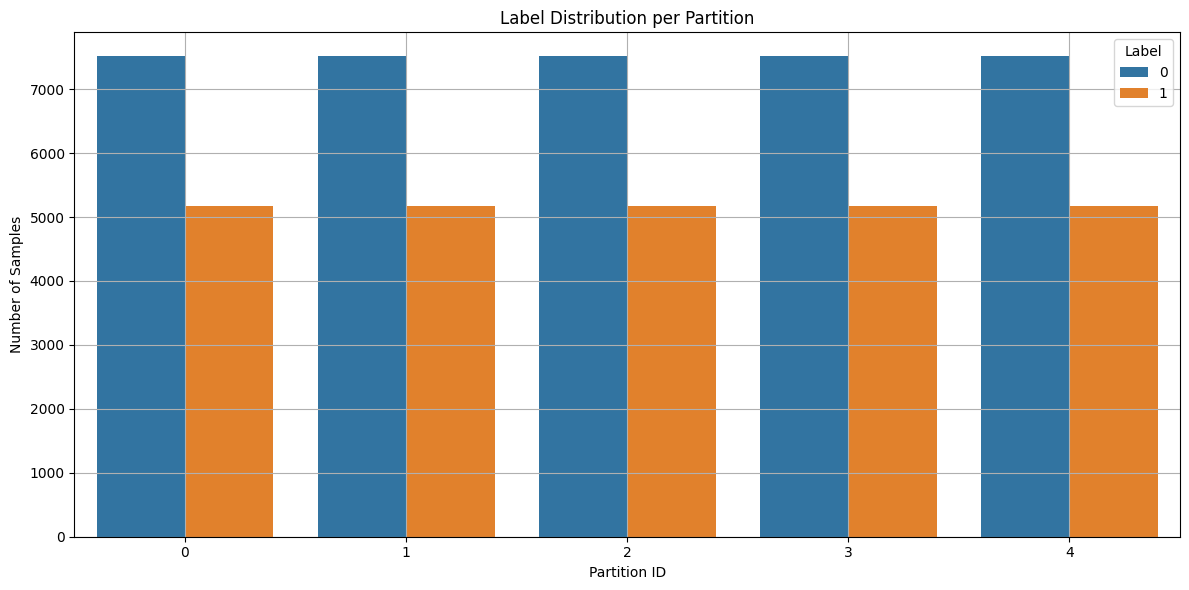

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
partition_df = get_partition_df(all_images, labels, num_partitions=5)
plot_label_distribution(partition_df)


In [ ]:
partition_df

,partition_id,label,count
0,0,0,7513
1,0,1,5172
2,1,0,7513
3,1,1,5172
4,2,0,7513
5,2,1,5172
6,3,0,7513
7,3,1,5172
8,4,0,7512
9,4,1,5173


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Statistics for Number of Examples per Partition

In [ ]:
partition_df.sum(1).describe()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,0
count,10.000000
mean,6345.000000
std,1233.078442
min,5173.000000
25%,5175.250000
50%,6345.500000
75%,7514.750000
max,7516.000000


### Calculate Mean Number of Updates Per Round

In [ ]:
(partition_df.sum(1) / BATCH_SIZE).apply(np.ceil)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,0
0,118.0
1,81.0
2,118.0
3,81.0
4,118.0
5,81.0
6,118.0
7,81.0
8,118.0
9,81.0


## Model training/evaluation (PyTorch)

In [ ]:
class MLPNet(nn.Module):
    def __init__(self) -> None:
        super(MLPNet, self).__init__()
        # self.conv_layers = nn.Sequential(
        #     nn.Conv2d(1, 16, kernel_size=3, padding=1),   # 1 input channel (grayscale), 16 output
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2),  # 64x64

        #     nn.Conv2d(16, 32, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2),  # 32x32
        # )
        self.fc_layers = nn.Sequential(
            nn.Linear(32*32 , 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1),   # Binary classification: output logit
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.softmax(self.layer3(x))
        return x

class KANNet(PureKAN):
    def __init__(self) -> None:
        super().__init__([32*32 , 24, 24, 1])

    def forward(self, x):
        # Flatten the input for KAN
        x = x.view(x.size(0), -1)
        return super().forward(x)

class FastKANNet(FastKAN):
    def __init__(self) -> None:
        super().__init__([32*32, 24, 24, 1])

    def forward(self, x):
        # Flatten the input for KAN
        x = x.view(x.size(0), -1)
        return super().forward(x)

def create_network(net_type: str):
    if net_type == "mlp":
        return MLPNet()
    elif net_type == "kan":
        return KANNet()
    elif net_type == "fastkan":
        return FastKANNet()
    else:
        raise ValueError(f"Unknown network type: {net_type}")

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def get_model_size_in_MB(parameters):
    total_bytes = 0
    for param in parameters:
        total_bytes += param.size * param.itemsize  # num elements * bytes per element
    return total_bytes / (1024 * 1024)  # Convert to MB


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(
        net.parameters(),
        lr=LEARNING_RATE,
        momentum=MOMENTUM)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["image"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predicted == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
        return epoch_loss, epoch_acc


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.BCEWithLogitsLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

## Flower Architecture

### Flower client

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, pid, net, trainloader, valloader=None):
        self.pid = pid  # partition ID of a client
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.pid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.pid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epoch_loss, epoch_accuracy = train(self.net, self.trainloader, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {"epoch_loss": float(epoch_loss),
                                                                 "epoch_accuracy": float(epoch_accuracy)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.pid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = create_network(NET_TYPE).to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, _ = load_datasets(partition_id, num_partitions)
    return FlowerClient(partition_id, net, trainloader).to_client()

### Server-side parameter **evaluation**

#### Save evaluation results

In [ ]:
def create_new_history():
    history = {"net_type": NET_TYPE,
              "test_accuracy": [],
              "test_loss": [],
              "train_accuracy": [0.0], # No fit metrics before the first round
              "train_loss": [0.0],
              "execution_time": 0,
              "seed": SEED,
              "batch_size": BATCH_SIZE,
              "local_epochs": LOCAL_EPOCHS,
              "fraction_clients": FRACTION_CLIENTS,
              "comm_rounds": COMM_ROUNDS,
              "num_partitions": NUM_PARTITIONS,
              "device": str(DEVICE),
              "learning_rate": LEARNING_RATE,
              "momentum": MOMENTUM,
              "Communication_sizes": [],
              }
    return history

# Need to use a global var because we can't pass our dictionary as argument
def save_test_metrics(server_round: int, accuracy: float, loss: float, model_size: float):
    HISTORY["test_accuracy"].append((accuracy, server_round))
    HISTORY["test_loss"].append((loss, server_round))
    HISTORY["Communication_sizes"].append((model_size, server_round))

# Currently can't capture the server round inside the fit aggregation function
def save_train_metrics(accuracy: float, loss: float):
    HISTORY["train_accuracy"].append(accuracy)
    HISTORY["train_loss"].append(loss)

def save_execution_time(execution_time: float):
    HISTORY["execution_time"] = execution_time

#### Evaluation function

In [ ]:
# The `evaluate` function will be called by Flower after every round
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = create_network(NET_TYPE).to(DEVICE)
    _, testloader = load_datasets(0, NUM_PARTITIONS)
    model_size = get_model_size_in_MB(parameters)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy} / Communication cost {model_size}")
    save_test_metrics(server_round, accuracy, loss, model_size)
    return loss, {"accuracy": accuracy}

### Training **Configuration** (e.g. epochs)




In [ ]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": LOCAL_EPOCHS,
    }
    return config

### Flower **Server**

#### Fit (training) Metrics Aggregation

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Inspired by https://github.com/adap/flower/blob/0e7c1b06c32ab90e0d3cf64825ed51eedd715509/examples/custom-mods/server.py"""

    # Get number of examples for each client used for training
    examples = [num_examples for num_examples, _ in metrics]

    # Multiply accuracy of each client by number of examples used
    train_losses = [
        num_examples * float(m["epoch_loss"]) for num_examples, m in metrics
    ]
    train_accuracies = [
        num_examples * float(m["epoch_accuracy"]) for num_examples, m in metrics
    ]

    train_loss = sum(train_losses) / sum(examples)
    train_accuracy = sum(train_accuracies) / sum(examples)

    save_train_metrics(train_accuracy, train_loss)

    # Aggregate and return custom metric (weighted average)
    return {
        "train_loss": sum(train_losses) / sum(examples),
        "train_accuracy": sum(train_accuracies) / sum(examples),
    }

#### Server function

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=FRACTION_CLIENTS,
        fraction_evaluate=0,
        min_fit_clients=1,
        min_evaluate_clients=0,
        min_available_clients=NUM_PARTITIONS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=evaluate,
        on_fit_config_fn=fit_config,
        fit_metrics_aggregation_fn=weighted_average,
    )

    config = ServerConfig(num_rounds=COMM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

## Helpers

### Get simulation execution time from Flower logs

In [ ]:
def get_elapsed_time(log_filepath) -> float:
    with open(log_filepath, 'r') as f:
        log_content = f.read()

        pattern = r'Run finished \d+ round\(s\) in (\d+\.\d+)s'
        regex_match = re.search(pattern, log_content)

        if regex_match:
            elapsed_time = float(regex_match.group(1))
            print(f"Simulation execution time: {elapsed_time} seconds")
            return elapsed_time
        else:
            print("Could not find elapsed time.")
            return None

## Simulation

### Global model **initialization**

In [ ]:
# Create an instance of the model and get the parameters
initial_model = create_network(NET_TYPE)
params = get_parameters(initial_model)
total_params = sum(p.numel() for p in initial_model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 226584


In [ ]:
params = get_parameters(initial_model)
sizes = []

for param in params:
  sizes.append(param.size * param.itemsize, )  # num elements * bytes per element
total_bytes = sum(sizes)
print("Total Size :", total_bytes / (1024 * 1024))  # Convert to MB

Total Size : 0.913421630859375


### Run Simulation

In [ ]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


### Serialize Results and Save to Google Drive

In [ ]:
# Define hardware resources
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_gpus": 0.25, "num_cpus": 2}}
else:
    backend_config = {"num_cpus": 2}

# backend_config = {"num_cpus": 2}

# NET_TYPE = ["mlp", kan]

# Create Apps
client = ClientApp(client_fn=client_fn)
server = ServerApp(server_fn=server_fn)

# create new history
HISTORY = create_new_history()

# Configure logs
log_id = f"log_{NET_TYPE}_seed_{SEED}"
log_filename = f"{log_id}.txt"
flwr.common.logger.configure(
    identifier=log_id,
    filename=log_filename)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

save_execution_time(get_elapsed_time(log_filename))

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=100, no round_timeout
INFO :      
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.02176816256966178, {'accuracy': 0.5905511811023622}
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return dat

Server-side evaluation loss 0.02176816256966178 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375


(pid=4096) 2025-09-29 13:37:36.401500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=4096) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=4096) E0000 00:00:1759153056.420778    4096 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=4096) E0000 00:00:1759153056.426646    4096 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=4096) W0000 00:00:1759153056.443433    4096 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=4096) W0000 00:00:1759153056.443459    4096 computation_placer.cc:177] computation placer already registered. Pleas

(ClientAppActor pid=4096) [Client 24, round 1] fit, config: {'server_round': 1, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021515440195798874, accuracy 0.59251968503937
(ClientAppActor pid=4096) [Client 30, round 1] fit, config: {'server_round': 1, 'local_epochs': 5}


(ClientAppActor pid=4096) /tmp/ipython-input-560303732.py:21: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
(ClientAppActor pid=4096) Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)


(ClientAppActor pid=4096) Epoch 1: train loss 0.0218805018812418, accuracy 0.5542406311637081
(ClientAppActor pid=4096) [Client 38, round 1] fit, config: {'server_round': 1, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021597178652882576, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 41, round 1] fit, config: {'server_round': 1, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02166232466697693, accuracy 0.5443786982248521
(ClientAppActor pid=4096) [Client 50, round 1] fit, config: {'server_round': 1, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021930767223238945, accuracy 0.5818540433925049
(ClientAppActor pid=4096) [Client 94, round 1] fit, config: {'server_round': 1, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021765096113085747, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 32, round 1] fit, config: {'server_round': 1, 'local_epochs': 5}
(ClientAppActor pid=4096) Epo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02150011993944645, accuracy 0.5649606299212598


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (1, 0.021316520811065914, {'accuracy': 0.5905511811023622}, 42.58326157600004)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021316520811065914 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 21, round 2] fit, config: {'server_round': 2, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021417638286948204, accuracy 0.59251968503937
(ClientAppActor pid=4096) [Client 28, round 2] fit, config: {'server_round': 2, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02147787995636463, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 57, round 2] fit, config: {'server_round': 2, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02161826565861702, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 60, round 2] fit, config: {'server_round': 2, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02225099503993988, accuracy 0.534516765285996
(ClientAppActor pid=4096) [Client 63, round 2] fit, config: {'server_round': 2, 'local_epochs': 5}
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021757831797003746, accuracy 0.5641025641025641


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (2, 0.021267973062560314, {'accuracy': 0.5905511811023622}, 57.92861669499996)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021267973062560314 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 0, round 3] fit, config: {'server_round': 3, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021547118201851845, accuracy 0.5767716535433071
(ClientAppActor pid=4096) [Client 4, round 3] fit, config: {'server_round': 3, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021512435749173164, accuracy 0.5649606299212598
(ClientAppActor pid=4096) [Client 16, round 3] fit, config: {'server_round': 3, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021550508216023445, accuracy 0.5905511811023622
(ClientAppActor pid=4096) [Client 43, round 3] fit, config: {'server_round': 3, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02182812988758087, accuracy 0.5483234714003945
(ClientAppActor pid=4096) [Client 63, round 3] fit, config: {'server_round': 3, 'local_epochs': 5}
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021749893203377724, accuracy 0.5739644970414202


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (3, 0.021174007982719602, {'accuracy': 0.5905511811023622}, 70.87262711799997)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021174007982719602 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 17, round 4] fit, config: {'server_round': 4, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02119944617152214, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 25, round 4] fit, config: {'server_round': 4, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021947842091321945, accuracy 0.5502958579881657
(ClientAppActor pid=4096) [Client 31, round 4] fit, config: {'server_round': 4, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.022485017776489258, accuracy 0.5542406311637081
(ClientAppActor pid=4096) [Client 48, round 4] fit, config: {'server_round': 4, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02152833715081215, accuracy 0.5739644970414202
(ClientAppActor pid=4096) [Client 91, round 4] fit, config: {'server_round': 4, 'local_epochs': 5}
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021631766110658646, accuracy 0.5779092702169625


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (4, 0.020900590682592916, {'accuracy': 0.5905511811023622}, 83.79561328399996)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.020900590682592916 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 17, round 5] fit, config: {'server_round': 5, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021235227584838867, accuracy 0.5885826771653543
(ClientAppActor pid=4096) [Client 19, round 5] fit, config: {'server_round': 5, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021277256309986115, accuracy 0.5846456692913385
(ClientAppActor pid=4096) [Client 39, round 5] fit, config: {'server_round': 5, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02146027237176895, accuracy 0.5581854043392505
(ClientAppActor pid=4096) [Client 55, round 5] fit, config: {'server_round': 5, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021192125976085663, accuracy 0.5818540433925049
(ClientAppActor pid=4096) [Client 75, round 5] fit, config: {'server_round': 5, 'local_epochs': 5}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (5, 0.020299806369571235, {'accuracy': 0.6220472440944882}, 96.20579685099995)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


(ClientAppActor pid=4096) Epoch 1: train loss 0.021066347137093544, accuracy 0.5857988165680473
Server-side evaluation loss 0.020299806369571235 / accuracy 0.6220472440944882 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 10, round 6] fit, config: {'server_round': 6, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02140183001756668, accuracy 0.5905511811023622
(ClientAppActor pid=4096) [Client 12, round 6] fit, config: {'server_round': 6, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021098008379340172, accuracy 0.6062992125984252
(ClientAppActor pid=4096) [Client 13, round 6] fit, config: {'server_round': 6, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021215563639998436, accuracy 0.5610236220472441
(ClientAppActor pid=4096) [Client 26, round 6] fit, config: {'server_round': 6, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02118709683418274, accuracy 0.5798816568047337
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02134486846625805, accuracy 0.5660749506903353


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (6, 0.02028735838537141, {'accuracy': 0.6141732283464567}, 108.948619108)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02028735838537141 / accuracy 0.6141732283464567 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 46, round 7] fit, config: {'server_round': 7, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021656621247529984, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 69, round 7] fit, config: {'server_round': 7, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02141113206744194, accuracy 0.5818540433925049
(ClientAppActor pid=4096) [Client 39, round 7] fit, config: {'server_round': 7, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02153393253684044, accuracy 0.5779092702169625
(ClientAppActor pid=4096) [Client 74, round 7] fit, config: {'server_round': 7, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021557943895459175, accuracy 0.5877712031558185
(ClientAppActor pid=4096) [Client 85, round 7] fit, config: {'server_round': 7, 'local_epochs': 5}
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021361874416470528, accuracy 0.5798816568047337


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (7, 0.022262246589961013, {'accuracy': 0.5905511811023622}, 121.08293552399994)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.022262246589961013 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 4, round 8] fit, config: {'server_round': 8, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021958528086543083, accuracy 0.5610236220472441
(ClientAppActor pid=4096) [Client 18, round 8] fit, config: {'server_round': 8, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.022040827199816704, accuracy 0.5531496062992126
(ClientAppActor pid=4096) [Client 21, round 8] fit, config: {'server_round': 8, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021664656698703766, accuracy 0.5669291338582677
(ClientAppActor pid=4096) [Client 46, round 8] fit, config: {'server_round': 8, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021646471694111824, accuracy 0.5384615384615384
(ClientAppActor pid=4096) [Client 58, round 8] fit, config: {'server_round': 8, 'local_epochs': 5}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02142457664012909, accuracy 0.571992110453649


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (8, 0.021459562102640706, {'accuracy': 0.5905511811023622}, 132.71711614100002)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021459562102640706 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 30, round 9] fit, config: {'server_round': 9, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02161448821425438, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 33, round 9] fit, config: {'server_round': 9, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021899811923503876, accuracy 0.5857988165680473
(ClientAppActor pid=4096) [Client 39, round 9] fit, config: {'server_round': 9, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02151942439377308, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 48, round 9] fit, config: {'server_round': 9, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021975448355078697, accuracy 0.5818540433925049
(ClientAppActor pid=4096) [Client 60, round 9] fit, config: {'server_round': 9, 'local_epochs': 5}
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021500417962670326, accuracy 0.5739644970414202


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (9, 0.020902105203763708, {'accuracy': 0.6062992125984252}, 144.24373885299997)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.020902105203763708 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 12, round 10] fit, config: {'server_round': 10, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021245963871479034, accuracy 0.6023622047244095
(ClientAppActor pid=4096) [Client 37, round 10] fit, config: {'server_round': 10, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021372061222791672, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 75, round 10] fit, config: {'server_round': 10, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02163730561733246, accuracy 0.6094674556213018
(ClientAppActor pid=4096) [Client 92, round 10] fit, config: {'server_round': 10, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.0214289128780365, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 94, round 10] fit, config: {'server_round': 10, 'local_epochs': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021495074033737183, accuracy 0.5700197238658777


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (10, 0.021472332984443725, {'accuracy': 0.5826771653543307}, 156.384391575)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021472332984443725 / accuracy 0.5826771653543307 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 0, round 11] fit, config: {'server_round': 11, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021576685830950737, accuracy 0.5964566929133859
(ClientAppActor pid=4096) [Client 4, round 11] fit, config: {'server_round': 11, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021472012624144554, accuracy 0.59251968503937
(ClientAppActor pid=4096) [Client 17, round 11] fit, config: {'server_round': 11, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02172667719423771, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 58, round 11] fit, config: {'server_round': 11, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021571598947048187, accuracy 0.5739644970414202
(ClientAppActor pid=4096) [Client 64, round 11] fit, config: {'server_round': 11, 'local_epochs': 5}

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02145346999168396, accuracy 0.591715976331361


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (11, 0.02115574878031813, {'accuracy': 0.5905511811023622}, 168.407141046)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02115574878031813 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 21, round 12] fit, config: {'server_round': 12, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.022121040150523186, accuracy 0.515748031496063
(ClientAppActor pid=4096) [Client 57, round 12] fit, config: {'server_round': 12, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021698756143450737, accuracy 0.5700197238658777
(ClientAppActor pid=4096) [Client 76, round 12] fit, config: {'server_round': 12, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021423619240522385, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 78, round 12] fit, config: {'server_round': 12, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02168000303208828, accuracy 0.5798816568047337
(ClientAppActor pid=4096) [Client 87, round 12] fit, config: {'server_round': 12, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021668966859579086, accuracy 0.5779092702169625


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (12, 0.0212070303639089, {'accuracy': 0.6141732283464567}, 180.62418219000006)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.0212070303639089 / accuracy 0.6141732283464567 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 15, round 13] fit, config: {'server_round': 13, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02225450612604618, accuracy 0.5433070866141733
(ClientAppActor pid=4096) [Client 19, round 13] fit, config: {'server_round': 13, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021838560700416565, accuracy 0.59251968503937
(ClientAppActor pid=4096) [Client 30, round 13] fit, config: {'server_round': 13, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021662844344973564, accuracy 0.5818540433925049
(ClientAppActor pid=4096) [Client 62, round 13] fit, config: {'server_round': 13, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02143782377243042, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 84, round 13] fit, config: {'server_round': 13, 'local_epochs': 5}

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02154194936156273, accuracy 0.5897435897435898


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (13, 0.021399446829097477, {'accuracy': 0.5905511811023622}, 192.66468774500004)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021399446829097477 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 35, round 14] fit, config: {'server_round': 14, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021687470376491547, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 45, round 14] fit, config: {'server_round': 14, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021555528044700623, accuracy 0.5542406311637081
(ClientAppActor pid=4096) [Client 50, round 14] fit, config: {'server_round': 14, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02149486541748047, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 57, round 14] fit, config: {'server_round': 14, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021534748375415802, accuracy 0.5877712031558185
(ClientAppActor pid=4096) [Client 70, round 14] fit, config: {'server_round': 14, 'local_epochs

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02139698527753353, accuracy 0.6074950690335306


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (14, 0.02114373116981326, {'accuracy': 0.6062992125984252}, 204.7363021010001)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02114373116981326 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 5, round 15] fit, config: {'server_round': 15, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021527359262108803, accuracy 0.5748031496062992
(ClientAppActor pid=4096) [Client 9, round 15] fit, config: {'server_round': 15, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021650047972798347, accuracy 0.5807086614173228
(ClientAppActor pid=4096) [Client 37, round 15] fit, config: {'server_round': 15, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021417662501335144, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 50, round 15] fit, config: {'server_round': 15, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02136554941534996, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 52, round 15] fit, config: {'server_round': 15, 'local_epochs': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02149665169417858, accuracy 0.5838264299802761


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (15, 0.021106791308545692, {'accuracy': 0.5905511811023622}, 215.7675549180001)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021106791308545692 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 16, round 16] fit, config: {'server_round': 16, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02150675095617771, accuracy 0.5433070866141733
(ClientAppActor pid=4096) [Client 35, round 16] fit, config: {'server_round': 16, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021426238119602203, accuracy 0.5857988165680473
(ClientAppActor pid=4096) [Client 52, round 16] fit, config: {'server_round': 16, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021333612501621246, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 55, round 16] fit, config: {'server_round': 16, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02158406190574169, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 56, round 16] fit, config: {'server_round': 16, 'local_epochs'

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (16, 0.021713177519520437, {'accuracy': 0.5433070866141733}, 226.97510001299997)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


(ClientAppActor pid=4096) Epoch 1: train loss 0.02155262976884842, accuracy 0.5531496062992126
Server-side evaluation loss 0.021713177519520437 / accuracy 0.5433070866141733 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 23, round 17] fit, config: {'server_round': 17, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021558081731200218, accuracy 0.5826771653543307
(ClientAppActor pid=4096) [Client 24, round 17] fit, config: {'server_round': 17, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021721579134464264, accuracy 0.5787401574803149
(ClientAppActor pid=4096) [Client 47, round 17] fit, config: {'server_round': 17, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021771837025880814, accuracy 0.5759368836291914
(ClientAppActor pid=4096) [Client 50, round 17] fit, config: {'server_round': 17, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02264367789030075, accuracy 0.5325443786982249


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (17, 0.021571450815426083, {'accuracy': 0.5905511811023622}, 238.58812906000003)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


(ClientAppActor pid=4096) Epoch 1: train loss 0.02271938882768154, accuracy 0.5108481262327417
Server-side evaluation loss 0.021571450815426083 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 24, round 18] fit, config: {'server_round': 18, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021349849179387093, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 45, round 18] fit, config: {'server_round': 18, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021755443885922432, accuracy 0.5562130177514792
(ClientAppActor pid=4096) [Client 71, round 18] fit, config: {'server_round': 18, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021549273282289505, accuracy 0.5601577909270217
(ClientAppActor pid=4096) [Client 83, round 18] fit, config: {'server_round': 18, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02131955511868, accuracy 0.5996055226824457
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021689577028155327, accuracy 0.5846456692913385


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (18, 0.021389668851386844, {'accuracy': 0.5984251968503937}, 250.49305127599996)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021389668851386844 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 6, round 19] fit, config: {'server_round': 19, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021558068692684174, accuracy 0.6023622047244095
(ClientAppActor pid=4096) [Client 9, round 19] fit, config: {'server_round': 19, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021401451900601387, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 27, round 19] fit, config: {'server_round': 19, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02141984924674034, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 67, round 19] fit, config: {'server_round': 19, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021642576903104782, accuracy 0.5877712031558185
(ClientAppActor pid=4096) [Client 74, round 19] fit, config: {'server_round': 19, 'local_epochs': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02133684605360031, accuracy 0.5936883629191322


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (19, 0.021262404486888976, {'accuracy': 0.6062992125984252}, 262.1064626760001)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021262404486888976 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 0, round 20] fit, config: {'server_round': 20, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02157791145145893, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 19, round 20] fit, config: {'server_round': 20, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021806851029396057, accuracy 0.5295275590551181
(ClientAppActor pid=4096) [Client 31, round 20] fit, config: {'server_round': 20, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02147086337208748, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 81, round 20] fit, config: {'server_round': 20, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02140968292951584, accuracy 0.6015779092702169
(ClientAppActor pid=4096) [Client 84, round 20] fit, config: {'server_round': 20, 'local_epochs': 5

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021456103771924973, accuracy 0.5956607495069034


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (20, 0.021241071186666415, {'accuracy': 0.5905511811023622}, 273.12493391399994)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021241071186666415 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 0, round 21] fit, config: {'server_round': 21, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021453212946653366, accuracy 0.5964566929133859
(ClientAppActor pid=4096) [Client 16, round 21] fit, config: {'server_round': 21, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021365048363804817, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 31, round 21] fit, config: {'server_round': 21, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021325338631868362, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 40, round 21] fit, config: {'server_round': 21, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021364115178585052, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 71, round 21] fit, config: {'server_round': 21, 'local_epochs'

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021311640739440918, accuracy 0.5964566929133859


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (21, 0.021200590715633603, {'accuracy': 0.5905511811023622}, 284.0256677509999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021200590715633603 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 7, round 22] fit, config: {'server_round': 22, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02146012894809246, accuracy 0.59251968503937
(ClientAppActor pid=4096) [Client 10, round 22] fit, config: {'server_round': 22, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021443448960781097, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 17, round 22] fit, config: {'server_round': 22, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02141687646508217, accuracy 0.5905511811023622
(ClientAppActor pid=4096) [Client 21, round 22] fit, config: {'server_round': 22, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02132696472108364, accuracy 0.5964566929133859
(ClientAppActor pid=4096) [Client 23, round 22] fit, config: {'server_round': 22, 'local_epochs': 5}


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021493367850780487, accuracy 0.5936883629191322


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (22, 0.0217389225021122, {'accuracy': 0.5905511811023622}, 296.13829288500006)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.0217389225021122 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 22, round 23] fit, config: {'server_round': 23, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021263645961880684, accuracy 0.6023622047244095
(ClientAppActor pid=4096) [Client 23, round 23] fit, config: {'server_round': 23, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021551387384533882, accuracy 0.5984251968503937
(ClientAppActor pid=4096) [Client 29, round 23] fit, config: {'server_round': 23, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02169898711144924, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 54, round 23] fit, config: {'server_round': 23, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021544167771935463, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 95, round 23] fit, config: {'server_round': 23, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021852998062968254, accuracy 0.591715976331361


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (23, 0.021325012830298716, {'accuracy': 0.5905511811023622}, 307.4361780219999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021325012830298716 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 34, round 24] fit, config: {'server_round': 24, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021350793540477753, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 62, round 24] fit, config: {'server_round': 24, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02148788794875145, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 84, round 24] fit, config: {'server_round': 24, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021659910678863525, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 92, round 24] fit, config: {'server_round': 24, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02205454371869564, accuracy 0.5404339250493096
(ClientAppActor pid=4096) [Client 33, round 24] fit, config: {'server_round': 24, 'local_epochs'

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02130461297929287, accuracy 0.5897435897435898


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (24, 0.021547587837759903, {'accuracy': 0.5905511811023622}, 318.85189306000007)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021547587837759903 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 5, round 25] fit, config: {'server_round': 25, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021880224347114563, accuracy 0.5334645669291339
(ClientAppActor pid=4096) [Client 9, round 25] fit, config: {'server_round': 25, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021384188905358315, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 55, round 25] fit, config: {'server_round': 25, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021421916782855988, accuracy 0.5877712031558185
(ClientAppActor pid=4096) [Client 60, round 25] fit, config: {'server_round': 25, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02152927592396736, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 76, round 25] fit, config: {'server_round': 25, 'local_epochs': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.022184547036886215, accuracy 0.5502958579881657


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (25, 0.02123413733610018, {'accuracy': 0.5905511811023622}, 330.7598633289999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02123413733610018 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 1, round 26] fit, config: {'server_round': 26, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02133103460073471, accuracy 0.5984251968503937
(ClientAppActor pid=4096) [Client 53, round 26] fit, config: {'server_round': 26, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021629996597766876, accuracy 0.5779092702169625
(ClientAppActor pid=4096) [Client 9, round 26] fit, config: {'server_round': 26, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021358603611588478, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 31, round 26] fit, config: {'server_round': 26, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021360499784350395, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 68, round 26] fit, config: {'server_round': 26, 'local_epochs': 5

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02146940492093563, accuracy 0.591715976331361


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (26, 0.02125755726821779, {'accuracy': 0.5905511811023622}, 341.525680469)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02125755726821779 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 5, round 27] fit, config: {'server_round': 27, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02149692177772522, accuracy 0.5551181102362205
(ClientAppActor pid=4096) [Client 12, round 27] fit, config: {'server_round': 27, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021437993273139, accuracy 0.5984251968503937
(ClientAppActor pid=4096) [Client 22, round 27] fit, config: {'server_round': 27, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02162405289709568, accuracy 0.5492125984251969
(ClientAppActor pid=4096) [Client 28, round 27] fit, config: {'server_round': 27, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021619947627186775, accuracy 0.5976331360946746
(ClientAppActor pid=4096) [Client 83, round 27] fit, config: {'server_round': 27, 'local_epochs': 5}


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021344654262065887, accuracy 0.5897435897435898


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (27, 0.02135928597037248, {'accuracy': 0.5905511811023622}, 352.73230973499994)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02135928597037248 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 46, round 28] fit, config: {'server_round': 28, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021497366949915886, accuracy 0.5857988165680473
(ClientAppActor pid=4096) [Client 52, round 28] fit, config: {'server_round': 28, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.0214129239320755, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 64, round 28] fit, config: {'server_round': 28, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.0218172799795866, accuracy 0.5818540433925049
(ClientAppActor pid=4096) [Client 68, round 28] fit, config: {'server_round': 28, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02184837870299816, accuracy 0.5621301775147929
(ClientAppActor pid=4096) [Client 88, round 28] fit, config: {'server_round': 28, 'local_epochs': 5}

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (28, 0.020771528322865645, {'accuracy': 0.5905511811023622}, 364.05017533599994)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


(ClientAppActor pid=4096) Epoch 1: train loss 0.021288609132170677, accuracy 0.5866141732283464
Server-side evaluation loss 0.020771528322865645 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 17, round 29] fit, config: {'server_round': 29, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02145490050315857, accuracy 0.5866141732283464
(ClientAppActor pid=4096) [Client 43, round 29] fit, config: {'server_round': 29, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021461522206664085, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 46, round 29] fit, config: {'server_round': 29, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021520186215639114, accuracy 0.5502958579881657
(ClientAppActor pid=4096) [Client 59, round 29] fit, config: {'server_round': 29, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021318921819329262, accuracy 0.5877712031558185

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021628649905323982, accuracy 0.591715976331361


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (29, 0.021255382402675358, {'accuracy': 0.5984251968503937}, 375.3701825400001)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021255382402675358 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 7, round 30] fit, config: {'server_round': 30, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021456295624375343, accuracy 0.5748031496062992
(ClientAppActor pid=4096) [Client 17, round 30] fit, config: {'server_round': 30, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02140081115067005, accuracy 0.5846456692913385
(ClientAppActor pid=4096) [Client 23, round 30] fit, config: {'server_round': 30, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02165333367884159, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 24, round 30] fit, config: {'server_round': 30, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021722372621297836, accuracy 0.5255905511811023
(ClientAppActor pid=4096) [Client 34, round 30] fit, config: {'server_round': 30, 'local_epochs': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021439310163259506, accuracy 0.5838264299802761


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (30, 0.021201651866041768, {'accuracy': 0.5984251968503937}, 386.62949103000005)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021201651866041768 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 22, round 31] fit, config: {'server_round': 31, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021971678361296654, accuracy 0.5354330708661418
(ClientAppActor pid=4096) [Client 35, round 31] fit, config: {'server_round': 31, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.022058680653572083, accuracy 0.5857988165680473
(ClientAppActor pid=4096) [Client 38, round 31] fit, config: {'server_round': 31, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021338367834687233, accuracy 0.6015779092702169
(ClientAppActor pid=4096) [Client 65, round 31] fit, config: {'server_round': 31, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021978463977575302, accuracy 0.5483234714003945
(ClientAppActor pid=4096) [Client 90, round 31] fit, config: {'server_round': 31, 'local_epoch

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021575376391410828, accuracy 0.5976331360946746


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (31, 0.02117112020807942, {'accuracy': 0.6062992125984252}, 396.72977858600007)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02117112020807942 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 37, round 32] fit, config: {'server_round': 32, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02151964232325554, accuracy 0.5779092702169625
(ClientAppActor pid=4096) [Client 70, round 32] fit, config: {'server_round': 32, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02143939584493637, accuracy 0.5798816568047337
(ClientAppActor pid=4096) [Client 12, round 32] fit, config: {'server_round': 32, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02131512202322483, accuracy 0.6003937007874016
(ClientAppActor pid=4096) [Client 17, round 32] fit, config: {'server_round': 32, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021277809515595436, accuracy 0.6003937007874016
(ClientAppActor pid=4096) [Client 90, round 32] fit, config: {'server_round': 32, 'local_epochs': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.0220350194722414, accuracy 0.5325443786982249


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (32, 0.021186659185905156, {'accuracy': 0.5984251968503937}, 408.17035269300004)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021186659185905156 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 2, round 33] fit, config: {'server_round': 33, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021458396688103676, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 13, round 33] fit, config: {'server_round': 33, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021296922117471695, accuracy 0.5964566929133859
(ClientAppActor pid=4096) [Client 25, round 33] fit, config: {'server_round': 33, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02182266302406788, accuracy 0.5542406311637081
(ClientAppActor pid=4096) [Client 31, round 33] fit, config: {'server_round': 33, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021570701152086258, accuracy 0.5976331360946746
(ClientAppActor pid=4096) [Client 56, round 33] fit, config: {'server_round': 33, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (33, 0.021138217974835494, {'accuracy': 0.6062992125984252}, 419.97946653100007)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


(ClientAppActor pid=4096) Epoch 1: train loss 0.021447990089654922, accuracy 0.5936883629191322
Server-side evaluation loss 0.021138217974835494 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 21, round 34] fit, config: {'server_round': 34, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02142777107656002, accuracy 0.5708661417322834
(ClientAppActor pid=4096) [Client 24, round 34] fit, config: {'server_round': 34, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021284185349941254, accuracy 0.5964566929133859
(ClientAppActor pid=4096) [Client 52, round 34] fit, config: {'server_round': 34, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021583592519164085, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 58, round 34] fit, config: {'server_round': 34, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021529538556933403, accuracy 0.5936883629191322

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021847175434231758, accuracy 0.5976331360946746


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (34, 0.021084711307615744, {'accuracy': 0.6062992125984252}, 431.39961130200004)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021084711307615744 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 30, round 35] fit, config: {'server_round': 35, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021664006635546684, accuracy 0.5877712031558185
(ClientAppActor pid=4096) [Client 45, round 35] fit, config: {'server_round': 35, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021600279957056046, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 50, round 35] fit, config: {'server_round': 35, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021734194830060005, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 57, round 35] fit, config: {'server_round': 35, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02166629396378994, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 62, round 35] fit, config: {'server_round': 35, 'local_epochs'

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021439526230096817, accuracy 0.6043307086614174


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (35, 0.021107831808525747, {'accuracy': 0.6062992125984252}, 442.97530131200006)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021107831808525747 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 16, round 36] fit, config: {'server_round': 36, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021427957341074944, accuracy 0.5885826771653543
(ClientAppActor pid=4096) [Client 20, round 36] fit, config: {'server_round': 36, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021456144750118256, accuracy 0.6003937007874016
(ClientAppActor pid=4096) [Client 28, round 36] fit, config: {'server_round': 36, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02136627398431301, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 49, round 36] fit, config: {'server_round': 36, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021454544737935066, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 75, round 36] fit, config: {'server_round': 36, 'local_epochs'

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021145019680261612, accuracy 0.6023622047244095


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (36, 0.021081575727838232, {'accuracy': 0.6062992125984252}, 453.4092270230001)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021081575727838232 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 20, round 37] fit, config: {'server_round': 37, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02148478478193283, accuracy 0.5846456692913385
(ClientAppActor pid=4096) [Client 25, round 37] fit, config: {'server_round': 37, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021243290975689888, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 52, round 37] fit, config: {'server_round': 37, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021460361778736115, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 59, round 37] fit, config: {'server_round': 37, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.0217544324696064, accuracy 0.5641025641025641
(ClientAppActor pid=4096) [Client 73, round 37] fit, config: {'server_round': 37, 'local_epochs': 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (37, 0.021036592994149277, {'accuracy': 0.6062992125984252}, 464.405290424)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


(ClientAppActor pid=4096) Epoch 1: train loss 0.021434133872389793, accuracy 0.5492125984251969
Server-side evaluation loss 0.021036592994149277 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 17, round 38] fit, config: {'server_round': 38, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.0212822537869215, accuracy 0.5984251968503937
(ClientAppActor pid=4096) [Client 27, round 38] fit, config: {'server_round': 38, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02162141166627407, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 37, round 38] fit, config: {'server_round': 38, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02125566452741623, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 55, round 38] fit, config: {'server_round': 38, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021317312493920326, accuracy 0.5857988165680473
(C

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02152274362742901, accuracy 0.5956607495069034


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (38, 0.021397959998273475, {'accuracy': 0.5984251968503937}, 475.60782628900006)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021397959998273475 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 10, round 39] fit, config: {'server_round': 39, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021286914125084877, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 11, round 39] fit, config: {'server_round': 39, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021500032395124435, accuracy 0.5984251968503937
(ClientAppActor pid=4096) [Client 34, round 39] fit, config: {'server_round': 39, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02118460275232792, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 45, round 39] fit, config: {'server_round': 39, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021666061133146286, accuracy 0.5700197238658777
(ClientAppActor pid=4096) [Client 75, round 39] fit, config: {'server_round': 39, 'local_epochs'

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02210082858800888, accuracy 0.5384615384615384


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (39, 0.021488433747779666, {'accuracy': 0.5984251968503937}, 487.22132876499995)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021488433747779666 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 5, round 40] fit, config: {'server_round': 40, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021871795877814293, accuracy 0.547244094488189
(ClientAppActor pid=4096) [Client 23, round 40] fit, config: {'server_round': 40, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021520880982279778, accuracy 0.5688976377952756
(ClientAppActor pid=4096) [Client 26, round 40] fit, config: {'server_round': 40, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02132180705666542, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 57, round 40] fit, config: {'server_round': 40, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02155645191669464, accuracy 0.5798816568047337
(ClientAppActor pid=4096) [Client 84, round 40] fit, config: {'server_round': 40, 'local_epochs': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021329984068870544, accuracy 0.5936883629191322


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (40, 0.02111974569756215, {'accuracy': 0.5905511811023622}, 497.84530939499996)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02111974569756215 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 2, round 41] fit, config: {'server_round': 41, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021270817145705223, accuracy 0.6003937007874016
(ClientAppActor pid=4096) [Client 4, round 41] fit, config: {'server_round': 41, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021668890491127968, accuracy 0.5826771653543307
(ClientAppActor pid=4096) [Client 35, round 41] fit, config: {'server_round': 41, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02165379747748375, accuracy 0.6015779092702169
(ClientAppActor pid=4096) [Client 45, round 41] fit, config: {'server_round': 41, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02160729467868805, accuracy 0.5502958579881657
(ClientAppActor pid=4096) [Client 48, round 41] fit, config: {'server_round': 41, 'local_epochs': 5

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (41, 0.020907975087954302, {'accuracy': 0.6141732283464567}, 508.442785963)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


(ClientAppActor pid=4096) Epoch 1: train loss 0.02157742716372013, accuracy 0.591715976331361
Server-side evaluation loss 0.020907975087954302 / accuracy 0.6141732283464567 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 15, round 42] fit, config: {'server_round': 42, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021303970366716385, accuracy 0.5846456692913385
(ClientAppActor pid=4096) [Client 30, round 42] fit, config: {'server_round': 42, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.022140905261039734, accuracy 0.5838264299802761
(ClientAppActor pid=4096) [Client 41, round 42] fit, config: {'server_round': 42, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021177638322114944, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 56, round 42] fit, config: {'server_round': 42, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021511254832148552, accuracy 0.5680473372781065


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021275673061609268, accuracy 0.5905511811023622


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (42, 0.02107580393318116, {'accuracy': 0.5905511811023622}, 519.652486643)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02107580393318116 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 15, round 43] fit, config: {'server_round': 43, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021254412829875946, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 18, round 43] fit, config: {'server_round': 43, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021332543343305588, accuracy 0.5866141732283464
(ClientAppActor pid=4096) [Client 21, round 43] fit, config: {'server_round': 43, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021081238985061646, accuracy 0.6023622047244095
(ClientAppActor pid=4096) [Client 25, round 43] fit, config: {'server_round': 43, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021720606833696365, accuracy 0.5443786982248521
(ClientAppActor pid=4096) [Client 70, round 43] fit, config: {'server_round': 43, 'local_epochs'

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021423302590847015, accuracy 0.5857988165680473


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (43, 0.02127843907498938, {'accuracy': 0.6456692913385826}, 530.768859199)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02127843907498938 / accuracy 0.6456692913385826 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 2, round 44] fit, config: {'server_round': 44, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02123435214161873, accuracy 0.5964566929133859
(ClientAppActor pid=4096) [Client 8, round 44] fit, config: {'server_round': 44, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021598035469651222, accuracy 0.5649606299212598
(ClientAppActor pid=4096) [Client 29, round 44] fit, config: {'server_round': 44, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021650424227118492, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 40, round 44] fit, config: {'server_round': 44, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021271562203764915, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 74, round 44] fit, config: {'server_round': 44, 'local_epochs': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02193957008421421, accuracy 0.5601577909270217


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (44, 0.021743671631249857, {'accuracy': 0.5984251968503937}, 541.982472548)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021743671631249857 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 1, round 45] fit, config: {'server_round': 45, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02127036452293396, accuracy 0.6003937007874016
(ClientAppActor pid=4096) [Client 11, round 45] fit, config: {'server_round': 45, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021761201322078705, accuracy 0.5885826771653543
(ClientAppActor pid=4096) [Client 34, round 45] fit, config: {'server_round': 45, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021445168182253838, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 41, round 45] fit, config: {'server_round': 45, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021503353491425514, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 60, round 45] fit, config: {'server_round': 45, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021554000675678253, accuracy 0.5581854043392505


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (45, 0.021104894754454845, {'accuracy': 0.5905511811023622}, 552.401957344)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021104894754454845 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 11, round 46] fit, config: {'server_round': 46, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021218637004494667, accuracy 0.6023622047244095
(ClientAppActor pid=4096) [Client 17, round 46] fit, config: {'server_round': 46, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02147960476577282, accuracy 0.6003937007874016
(ClientAppActor pid=4096) [Client 25, round 46] fit, config: {'server_round': 46, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021423693746328354, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 73, round 46] fit, config: {'server_round': 46, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021869979798793793, accuracy 0.5384615384615384
(ClientAppActor pid=4096) [Client 74, round 46] fit, config: {'server_round': 46, 'local_epochs

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021392131224274635, accuracy 0.5905511811023622


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (46, 0.02116228370215949, {'accuracy': 0.6141732283464567}, 563.230659907)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02116228370215949 / accuracy 0.6141732283464567 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 22, round 47] fit, config: {'server_round': 47, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021405929699540138, accuracy 0.5964566929133859
(ClientAppActor pid=4096) [Client 23, round 47] fit, config: {'server_round': 47, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021218780428171158, accuracy 0.6003937007874016
(ClientAppActor pid=4096) [Client 38, round 47] fit, config: {'server_round': 47, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021474137902259827, accuracy 0.5621301775147929
(ClientAppActor pid=4096) [Client 51, round 47] fit, config: {'server_round': 47, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021366218104958534, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 72, round 47] fit, config: {'server_round': 47, 'local_epochs

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021281704306602478, accuracy 0.5984251968503937


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (47, 0.02129519830538532, {'accuracy': 0.5984251968503937}, 574.564805703)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02129519830538532 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 22, round 48] fit, config: {'server_round': 48, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021260062232613564, accuracy 0.5570866141732284
(ClientAppActor pid=4096) [Client 33, round 48] fit, config: {'server_round': 48, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02117777056992054, accuracy 0.6035502958579881
(ClientAppActor pid=4096) [Client 59, round 48] fit, config: {'server_round': 48, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021387014538049698, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 86, round 48] fit, config: {'server_round': 48, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021292410790920258, accuracy 0.5976331360946746
(ClientAppActor pid=4096) [Client 88, round 48] fit, config: {'server_round': 48, 'local_epochs'

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021508896723389626, accuracy 0.5936883629191322


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (48, 0.02116493305822057, {'accuracy': 0.5984251968503937}, 585.875319946)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02116493305822057 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 32, round 49] fit, config: {'server_round': 49, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02126299776136875, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 66, round 49] fit, config: {'server_round': 49, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02173476107418537, accuracy 0.5424063116370809
(ClientAppActor pid=4096) [Client 76, round 49] fit, config: {'server_round': 49, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02148992381989956, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 84, round 49] fit, config: {'server_round': 49, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021459663286805153, accuracy 0.5877712031558185
(ClientAppActor pid=4096) [Client 92, round 49] fit, config: {'server_round': 49, 'local_epochs': 5

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02140394225716591, accuracy 0.5522682445759369


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (49, 0.021647646201877143, {'accuracy': 0.6062992125984252}, 596.7987020129999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021647646201877143 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 15, round 50] fit, config: {'server_round': 50, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021436303853988647, accuracy 0.5984251968503937
(ClientAppActor pid=4096) [Client 16, round 50] fit, config: {'server_round': 50, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021450534462928772, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 61, round 50] fit, config: {'server_round': 50, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021506138145923615, accuracy 0.5877712031558185
(ClientAppActor pid=4096) [Client 64, round 50] fit, config: {'server_round': 50, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021728767082095146, accuracy 0.5838264299802761
(ClientAppActor pid=4096) [Client 71, round 50] fit, config: {'server_round': 50, 'local_epochs

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021585319191217422, accuracy 0.591715976331361


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (50, 0.021075459446494034, {'accuracy': 0.6220472440944882}, 607.10464766)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 51]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021075459446494034 / accuracy 0.6220472440944882 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 5, round 51] fit, config: {'server_round': 51, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021740704774856567, accuracy 0.5551181102362205
(ClientAppActor pid=4096) [Client 21, round 51] fit, config: {'server_round': 51, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021479278802871704, accuracy 0.5984251968503937
(ClientAppActor pid=4096) [Client 75, round 51] fit, config: {'server_round': 51, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021311532706022263, accuracy 0.5838264299802761
(ClientAppActor pid=4096) [Client 83, round 51] fit, config: {'server_round': 51, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021283818408846855, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 87, round 51] fit, config: {'server_round': 51, 'local_epochs

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021407831460237503, accuracy 0.5877712031558185


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (51, 0.020859819697582816, {'accuracy': 0.5984251968503937}, 618.5149501020001)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 52]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.020859819697582816 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 26, round 52] fit, config: {'server_round': 52, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021320540457963943, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 40, round 52] fit, config: {'server_round': 52, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02117198519408703, accuracy 0.5976331360946746
(ClientAppActor pid=4096) [Client 45, round 52] fit, config: {'server_round': 52, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02127365581691265, accuracy 0.6015779092702169
(ClientAppActor pid=4096) [Client 90, round 52] fit, config: {'server_round': 52, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02124146930873394, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 92, round 52] fit, config: {'server_round': 52, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021184870973229408, accuracy 0.6181102362204725


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (52, 0.021072429934824544, {'accuracy': 0.5984251968503937}, 629.833072059)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 53]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021072429934824544 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 6, round 53] fit, config: {'server_round': 53, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021125895902514458, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 26, round 53] fit, config: {'server_round': 53, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02155892923474312, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 65, round 53] fit, config: {'server_round': 53, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021309351548552513, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 70, round 53] fit, config: {'server_round': 53, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021296290680766106, accuracy 0.5976331360946746
(ClientAppActor pid=4096) [Client 72, round 53] fit, config: {'server_round': 53, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021077249199151993, accuracy 0.5976331360946746


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (53, 0.020774477579462245, {'accuracy': 0.6062992125984252}, 641.059648082)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 54]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.020774477579462245 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 88, round 54] fit, config: {'server_round': 54, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021147841587662697, accuracy 0.6035502958579881
(ClientAppActor pid=4096) [Client 1, round 54] fit, config: {'server_round': 54, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021041598170995712, accuracy 0.59251968503937
(ClientAppActor pid=4096) [Client 14, round 54] fit, config: {'server_round': 54, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02116624265909195, accuracy 0.5846456692913385
(ClientAppActor pid=4096) [Client 61, round 54] fit, config: {'server_round': 54, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021290047094225883, accuracy 0.5838264299802761
(ClientAppActor pid=4096) [Client 68, round 54] fit, config: {'server_round': 54, 'local_epochs': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02121208980679512, accuracy 0.5984251968503937


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (54, 0.02086782455444336, {'accuracy': 0.6377952755905512}, 651.785179062)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 55]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02086782455444336 / accuracy 0.6377952755905512 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 44, round 55] fit, config: {'server_round': 55, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021361256018280983, accuracy 0.5976331360946746
(ClientAppActor pid=4096) [Client 45, round 55] fit, config: {'server_round': 55, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02138863131403923, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 66, round 55] fit, config: {'server_round': 55, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021426312625408173, accuracy 0.5818540433925049
(ClientAppActor pid=4096) [Client 71, round 55] fit, config: {'server_round': 55, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021202903240919113, accuracy 0.6015779092702169
(ClientAppActor pid=4096) [Client 77, round 55] fit, config: {'server_round': 55, 'local_epochs'

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02106902003288269, accuracy 0.6043307086614174


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (55, 0.02063996116007407, {'accuracy': 0.5984251968503937}, 662.584503387)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 56]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02063996116007407 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 0, round 56] fit, config: {'server_round': 56, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021293899044394493, accuracy 0.59251968503937
(ClientAppActor pid=4096) [Client 2, round 56] fit, config: {'server_round': 56, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021125370636582375, accuracy 0.59251968503937
(ClientAppActor pid=4096) [Client 14, round 56] fit, config: {'server_round': 56, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021192805841565132, accuracy 0.6023622047244095
(ClientAppActor pid=4096) [Client 26, round 56] fit, config: {'server_round': 56, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021393852308392525, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 38, round 56] fit, config: {'server_round': 56, 'local_epochs': 5}


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02099112793803215, accuracy 0.5996055226824457


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (56, 0.020280637609677053, {'accuracy': 0.6377952755905512}, 673.8977639699999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 57]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.020280637609677053 / accuracy 0.6377952755905512 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 17, round 57] fit, config: {'server_round': 57, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021256500855088234, accuracy 0.5964566929133859
(ClientAppActor pid=4096) [Client 27, round 57] fit, config: {'server_round': 57, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.0209343321621418, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 36, round 57] fit, config: {'server_round': 57, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.020518524572253227, accuracy 0.5798816568047337
(ClientAppActor pid=4096) [Client 58, round 57] fit, config: {'server_round': 57, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021741705015301704, accuracy 0.5621301775147929
(ClientAppActor pid=4096) [Client 65, round 57] fit, config: {'server_round': 57, 'local_epochs'

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021062184125185013, accuracy 0.5936883629191322


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (57, 0.020859435787351114, {'accuracy': 0.5984251968503937}, 685.471681669)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 58]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.020859435787351114 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 5, round 58] fit, config: {'server_round': 58, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021671222522854805, accuracy 0.5393700787401575
(ClientAppActor pid=4096) [Client 10, round 58] fit, config: {'server_round': 58, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021453550085425377, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 22, round 58] fit, config: {'server_round': 58, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02154884673655033, accuracy 0.5570866141732284
(ClientAppActor pid=4096) [Client 31, round 58] fit, config: {'server_round': 58, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.020781267434358597, accuracy 0.6134122287968442
(ClientAppActor pid=4096) [Client 54, round 58] fit, config: {'server_round': 58, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02161501534283161, accuracy 0.5542406311637081


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (58, 0.021121428707453208, {'accuracy': 0.6141732283464567}, 696.7721684549999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 59]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021121428707453208 / accuracy 0.6141732283464567 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 13, round 59] fit, config: {'server_round': 59, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02106725610792637, accuracy 0.6043307086614174
(ClientAppActor pid=4096) [Client 17, round 59] fit, config: {'server_round': 59, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021163763478398323, accuracy 0.6023622047244095
(ClientAppActor pid=4096) [Client 24, round 59] fit, config: {'server_round': 59, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021557865664362907, accuracy 0.5649606299212598
(ClientAppActor pid=4096) [Client 25, round 59] fit, config: {'server_round': 59, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021366318687796593, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 27, round 59] fit, config: {'server_round': 59, 'local_epochs

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02122945338487625, accuracy 0.6023622047244095


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (59, 0.0206055383043965, {'accuracy': 0.6062992125984252}, 706.6657161349999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 60]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.0206055383043965 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 9, round 60] fit, config: {'server_round': 60, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02150401845574379, accuracy 0.5748031496062992
(ClientAppActor pid=4096) [Client 21, round 60] fit, config: {'server_round': 60, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021156085655093193, accuracy 0.59251968503937
(ClientAppActor pid=4096) [Client 34, round 60] fit, config: {'server_round': 60, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021382633596658707, accuracy 0.5818540433925049
(ClientAppActor pid=4096) [Client 41, round 60] fit, config: {'server_round': 60, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021142931655049324, accuracy 0.6035502958579881
(ClientAppActor pid=4096) [Client 52, round 60] fit, config: {'server_round': 60, 'local_epochs': 5}

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02095821686089039, accuracy 0.5996055226824457


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (60, 0.021111795282739355, {'accuracy': 0.6062992125984252}, 717.9852989199999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 61]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021111795282739355 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 12, round 61] fit, config: {'server_round': 61, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02093619480729103, accuracy 0.6043307086614174
(ClientAppActor pid=4096) [Client 36, round 61] fit, config: {'server_round': 61, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021453268826007843, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 64, round 61] fit, config: {'server_round': 61, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021689750254154205, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 72, round 61] fit, config: {'server_round': 61, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021453630179166794, accuracy 0.6055226824457594
(ClientAppActor pid=4096) [Client 77, round 61] fit, config: {'server_round': 61, 'local_epochs

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021001216024160385, accuracy 0.6232741617357002


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (61, 0.0214337748805369, {'accuracy': 0.5669291338582677}, 729.7046584760001)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 62]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.0214337748805369 / accuracy 0.5669291338582677 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 4, round 62] fit, config: {'server_round': 62, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021562017500400543, accuracy 0.6003937007874016
(ClientAppActor pid=4096) [Client 6, round 62] fit, config: {'server_round': 62, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021828895434737206, accuracy 0.5275590551181102
(ClientAppActor pid=4096) [Client 12, round 62] fit, config: {'server_round': 62, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021331097930669785, accuracy 0.5905511811023622
(ClientAppActor pid=4096) [Client 64, round 62] fit, config: {'server_round': 62, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02157880924642086, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 69, round 62] fit, config: {'server_round': 62, 'local_epochs': 5

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.020682359114289284, accuracy 0.631163708086785


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (62, 0.02130642087440791, {'accuracy': 0.5984251968503937}, 741.1116702439999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 63]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02130642087440791 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 11, round 63] fit, config: {'server_round': 63, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02113943360745907, accuracy 0.6003937007874016
(ClientAppActor pid=4096) [Client 46, round 63] fit, config: {'server_round': 63, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02146567776799202, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 47, round 63] fit, config: {'server_round': 63, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02136843465268612, accuracy 0.6094674556213018
(ClientAppActor pid=4096) [Client 71, round 63] fit, config: {'server_round': 63, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02132890559732914, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 91, round 63] fit, config: {'server_round': 63, 'local_epochs': 5}

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02102571539580822, accuracy 0.6015779092702169


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (63, 0.02097162440067201, {'accuracy': 0.6220472440944882}, 752.04823625)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 64]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02097162440067201 / accuracy 0.6220472440944882 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 7, round 64] fit, config: {'server_round': 64, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021456733345985413, accuracy 0.5905511811023622
(ClientAppActor pid=4096) [Client 8, round 64] fit, config: {'server_round': 64, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021241601556539536, accuracy 0.6003937007874016
(ClientAppActor pid=4096) [Client 11, round 64] fit, config: {'server_round': 64, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02123505249619484, accuracy 0.5984251968503937
(ClientAppActor pid=4096) [Client 26, round 64] fit, config: {'server_round': 64, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021217603236436844, accuracy 0.6094674556213018
(ClientAppActor pid=4096) [Client 32, round 64] fit, config: {'server_round': 64, 'local_epochs': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.0213058702647686, accuracy 0.5996055226824457


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (64, 0.02096479849552545, {'accuracy': 0.6141732283464567}, 762.2821722829999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 65]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02096479849552545 / accuracy 0.6141732283464567 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 58, round 65] fit, config: {'server_round': 65, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.022075165063142776, accuracy 0.5857988165680473
(ClientAppActor pid=4096) [Client 62, round 65] fit, config: {'server_round': 65, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021582547575235367, accuracy 0.5818540433925049
(ClientAppActor pid=4096) [Client 75, round 65] fit, config: {'server_round': 65, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021571094170212746, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 78, round 65] fit, config: {'server_round': 65, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021340135484933853, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 80, round 65] fit, config: {'server_round': 65, 'local_epochs

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021383527666330338, accuracy 0.5660749506903353


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (65, 0.020924432071175163, {'accuracy': 0.6220472440944882}, 773.777181211)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 66]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.020924432071175163 / accuracy 0.6220472440944882 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 4, round 66] fit, config: {'server_round': 66, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02108858898282051, accuracy 0.6082677165354331
(ClientAppActor pid=4096) [Client 9, round 66] fit, config: {'server_round': 66, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021261217072606087, accuracy 0.6043307086614174
(ClientAppActor pid=4096) [Client 44, round 66] fit, config: {'server_round': 66, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02128911018371582, accuracy 0.6015779092702169
(ClientAppActor pid=4096) [Client 50, round 66] fit, config: {'server_round': 66, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021198639646172523, accuracy 0.611439842209073
(ClientAppActor pid=4096) [Client 69, round 66] fit, config: {'server_round': 66, 'local_epochs': 5

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02119334042072296, accuracy 0.6003937007874016


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (66, 0.020559260225671484, {'accuracy': 0.6141732283464567}, 785.029426397)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 67]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.020559260225671484 / accuracy 0.6141732283464567 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 4, round 67] fit, config: {'server_round': 67, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021119847893714905, accuracy 0.5984251968503937
(ClientAppActor pid=4096) [Client 25, round 67] fit, config: {'server_round': 67, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021281279623508453, accuracy 0.6015779092702169
(ClientAppActor pid=4096) [Client 43, round 67] fit, config: {'server_round': 67, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021138768643140793, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 61, round 67] fit, config: {'server_round': 67, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021646132692694664, accuracy 0.5601577909270217
(ClientAppActor pid=4096) [Client 62, round 67] fit, config: {'server_round': 67, 'local_epochs'

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (67, 0.021155783510583594, {'accuracy': 0.6220472440944882}, 796.1255451929999)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 68]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


(ClientAppActor pid=4096) Epoch 1: train loss 0.02181699499487877, accuracy 0.5207100591715976
Server-side evaluation loss 0.021155783510583594 / accuracy 0.6220472440944882 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 6, round 68] fit, config: {'server_round': 68, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021288111805915833, accuracy 0.6082677165354331
(ClientAppActor pid=4096) [Client 18, round 68] fit, config: {'server_round': 68, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02143958956003189, accuracy 0.59251968503937
(ClientAppActor pid=4096) [Client 26, round 68] fit, config: {'server_round': 68, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02126709744334221, accuracy 0.6074950690335306
(ClientAppActor pid=4096) [Client 48, round 68] fit, config: {'server_round': 68, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021316058933734894, accuracy 0.6035502958579881
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021665675565600395, accuracy 0.5463510848126233


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (68, 0.02098334492660883, {'accuracy': 0.6299212598425197}, 806.3879253919999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 69]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02098334492660883 / accuracy 0.6299212598425197 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 46, round 69] fit, config: {'server_round': 69, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.0215586069971323, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 52, round 69] fit, config: {'server_round': 69, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021400995552539825, accuracy 0.5838264299802761
(ClientAppActor pid=4096) [Client 55, round 69] fit, config: {'server_round': 69, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021443163976073265, accuracy 0.5818540433925049
(ClientAppActor pid=4096) [Client 62, round 69] fit, config: {'server_round': 69, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02157522365450859, accuracy 0.5798816568047337
(ClientAppActor pid=4096) [Client 74, round 69] fit, config: {'server_round': 69, 'local_epochs': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02131270430982113, accuracy 0.5826771653543307


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (69, 0.020973457126166876, {'accuracy': 0.6141732283464567}, 817.412675926)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 70]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.020973457126166876 / accuracy 0.6141732283464567 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 3, round 70] fit, config: {'server_round': 70, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021177859976887703, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 9, round 70] fit, config: {'server_round': 70, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02152431569993496, accuracy 0.5767716535433071
(ClientAppActor pid=4096) [Client 29, round 70] fit, config: {'server_round': 70, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02139863558113575, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 54, round 70] fit, config: {'server_round': 70, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021485645323991776, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 62, round 70] fit, config: {'server_round': 70, 'local_epochs': 5

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021261226385831833, accuracy 0.5984251968503937


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (70, 0.021275021898464894, {'accuracy': 0.5984251968503937}, 828.743951231)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 71]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021275021898464894 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 14, round 71] fit, config: {'server_round': 71, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02132011391222477, accuracy 0.6043307086614174
(ClientAppActor pid=4096) [Client 39, round 71] fit, config: {'server_round': 71, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02162429690361023, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 43, round 71] fit, config: {'server_round': 71, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021203264594078064, accuracy 0.6015779092702169
(ClientAppActor pid=4096) [Client 47, round 71] fit, config: {'server_round': 71, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02114252932369709, accuracy 0.6173570019723866
(ClientAppActor pid=4096) [Client 58, round 71] fit, config: {'server_round': 71, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (71, 0.021172874555813046, {'accuracy': 0.5826771653543307}, 840.072959132)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 72]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


(ClientAppActor pid=4096) Epoch 1: train loss 0.02129155956208706, accuracy 0.5866141732283464
Server-side evaluation loss 0.021172874555813046 / accuracy 0.5826771653543307 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 10, round 72] fit, config: {'server_round': 72, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021236799657344818, accuracy 0.59251968503937
(ClientAppActor pid=4096) [Client 16, round 72] fit, config: {'server_round': 72, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02182563580572605, accuracy 0.547244094488189
(ClientAppActor pid=4096) [Client 19, round 72] fit, config: {'server_round': 72, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021348346024751663, accuracy 0.5807086614173228
(ClientAppActor pid=4096) [Client 35, round 72] fit, config: {'server_round': 72, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021525977179408073, accuracy 0.5936883629191322
(Cl

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.0213029645383358, accuracy 0.6015779092702169


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (72, 0.020920414624251718, {'accuracy': 0.5905511811023622}, 850.8226752129999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 73]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.020920414624251718 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 17, round 73] fit, config: {'server_round': 73, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021265512332320213, accuracy 0.5688976377952756
(ClientAppActor pid=4096) [Client 19, round 73] fit, config: {'server_round': 73, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021167941391468048, accuracy 0.6043307086614174
(ClientAppActor pid=4096) [Client 37, round 73] fit, config: {'server_round': 73, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.022119995206594467, accuracy 0.5266272189349113
(ClientAppActor pid=4096) [Client 39, round 73] fit, config: {'server_round': 73, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021178748458623886, accuracy 0.6094674556213018
(ClientAppActor pid=4096) [Client 49, round 73] fit, config: {'server_round': 73, 'local_epoch

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021457118913531303, accuracy 0.6003937007874016


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (73, 0.021815614906821663, {'accuracy': 0.5905511811023622}, 861.14992334)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 74]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021815614906821663 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 18, round 74] fit, config: {'server_round': 74, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02115878462791443, accuracy 0.5728346456692913
(ClientAppActor pid=4096) [Client 48, round 74] fit, config: {'server_round': 74, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02146957814693451, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 65, round 74] fit, config: {'server_round': 74, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021247267723083496, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 88, round 74] fit, config: {'server_round': 74, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021091362461447716, accuracy 0.6015779092702169
(ClientAppActor pid=4096) [Client 93, round 74] fit, config: {'server_round': 74, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02166144549846649, accuracy 0.5562130177514792


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (74, 0.02109799563415407, {'accuracy': 0.6062992125984252}, 872.4475938850001)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 75]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02109799563415407 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 9, round 75] fit, config: {'server_round': 75, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021251851692795753, accuracy 0.5984251968503937
(ClientAppActor pid=4096) [Client 21, round 75] fit, config: {'server_round': 75, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021358083933591843, accuracy 0.5885826771653543
(ClientAppActor pid=4096) [Client 24, round 75] fit, config: {'server_round': 75, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021275170147418976, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 43, round 75] fit, config: {'server_round': 75, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021334797143936157, accuracy 0.5976331360946746
(ClientAppActor pid=4096) [Client 53, round 75] fit, config: {'server_round': 75, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021493880078196526, accuracy 0.5964566929133859


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (75, 0.02107896954994502, {'accuracy': 0.6062992125984252}, 883.5807705289999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 76]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02107896954994502 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 12, round 76] fit, config: {'server_round': 76, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021459011361002922, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 26, round 76] fit, config: {'server_round': 76, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021285396069288254, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 48, round 76] fit, config: {'server_round': 76, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02117638662457466, accuracy 0.6074950690335306
(ClientAppActor pid=4096) [Client 50, round 76] fit, config: {'server_round': 76, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021103326231241226, accuracy 0.6094674556213018
(ClientAppActor pid=4096) [Client 69, round 76] fit, config: {'server_round': 76, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02141467109322548, accuracy 0.5956607495069034


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (76, 0.020988225467561735, {'accuracy': 0.6299212598425197}, 894.8833806099999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 77]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.020988225467561735 / accuracy 0.6299212598425197 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 2, round 77] fit, config: {'server_round': 77, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021578259766101837, accuracy 0.5984251968503937
(ClientAppActor pid=4096) [Client 13, round 77] fit, config: {'server_round': 77, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021183418110013008, accuracy 0.610236220472441
(ClientAppActor pid=4096) [Client 55, round 77] fit, config: {'server_round': 77, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02127731405198574, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 62, round 77] fit, config: {'server_round': 77, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021502070128917694, accuracy 0.5838264299802761
(ClientAppActor pid=4096) [Client 66, round 77] fit, config: {'server_round': 77, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021343544125556946, accuracy 0.5779092702169625


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (77, 0.02087403798666526, {'accuracy': 0.6141732283464567}, 905.2157231219999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 78]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02087403798666526 / accuracy 0.6141732283464567 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 41, round 78] fit, config: {'server_round': 78, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02128962054848671, accuracy 0.6094674556213018
(ClientAppActor pid=4096) [Client 45, round 78] fit, config: {'server_round': 78, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02119917795062065, accuracy 0.6055226824457594
(ClientAppActor pid=4096) [Client 52, round 78] fit, config: {'server_round': 78, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021306484937667847, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 62, round 78] fit, config: {'server_round': 78, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.0212669987231493, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 64, round 78] fit, config: {'server_round': 78, 'local_epochs': 5}


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02081211842596531, accuracy 0.6074950690335306


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (78, 0.02081431178596076, {'accuracy': 0.5984251968503937}, 916.157520325)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 79]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02081431178596076 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 56, round 79] fit, config: {'server_round': 79, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02137055993080139, accuracy 0.6035502958579881
(ClientAppActor pid=4096) [Client 6, round 79] fit, config: {'server_round': 79, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021184077486395836, accuracy 0.6122047244094488
(ClientAppActor pid=4096) [Client 25, round 79] fit, config: {'server_round': 79, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021465947851538658, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 40, round 79] fit, config: {'server_round': 79, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021330447867512703, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 69, round 79] fit, config: {'server_round': 79, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02121743932366371, accuracy 0.5936883629191322


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (79, 0.02082867885199119, {'accuracy': 0.6299212598425197}, 927.3927383539999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 80]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02082867885199119 / accuracy 0.6299212598425197 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 35, round 80] fit, config: {'server_round': 80, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02069825679063797, accuracy 0.6469428007889546
(ClientAppActor pid=4096) [Client 46, round 80] fit, config: {'server_round': 80, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.020959695801138878, accuracy 0.631163708086785
(ClientAppActor pid=4096) [Client 51, round 80] fit, config: {'server_round': 80, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02127285860478878, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 80, round 80] fit, config: {'server_round': 80, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021107317879796028, accuracy 0.6094674556213018
(ClientAppActor pid=4096) [Client 85, round 80] fit, config: {'server_round': 80, 'local_epochs': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021541381254792213, accuracy 0.5976331360946746


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (80, 0.021076248856041375, {'accuracy': 0.6062992125984252}, 938.609829148)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 81]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021076248856041375 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 19, round 81] fit, config: {'server_round': 81, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021069642156362534, accuracy 0.6023622047244095
(ClientAppActor pid=4096) [Client 33, round 81] fit, config: {'server_round': 81, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021640878170728683, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 52, round 81] fit, config: {'server_round': 81, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.020975308492779732, accuracy 0.621301775147929
(ClientAppActor pid=4096) [Client 81, round 81] fit, config: {'server_round': 81, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02120720036327839, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 89, round 81] fit, config: {'server_round': 81, 'local_epochs': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021290935575962067, accuracy 0.5936883629191322


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (81, 0.021084975539229986, {'accuracy': 0.5826771653543307}, 949.423611462)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 82]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021084975539229986 / accuracy 0.5826771653543307 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 22, round 82] fit, config: {'server_round': 82, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021275412291288376, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 27, round 82] fit, config: {'server_round': 82, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021553531289100647, accuracy 0.5739644970414202
(ClientAppActor pid=4096) [Client 31, round 82] fit, config: {'server_round': 82, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021197855472564697, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 36, round 82] fit, config: {'server_round': 82, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02113419957458973, accuracy 0.611439842209073
(ClientAppActor pid=4096) [Client 43, round 82] fit, config: {'server_round': 82, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021361902356147766, accuracy 0.5964566929133859


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (82, 0.020959435485479398, {'accuracy': 0.6062992125984252}, 959.722759901)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 83]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.020959435485479398 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 12, round 83] fit, config: {'server_round': 83, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021250026300549507, accuracy 0.5885826771653543
(ClientAppActor pid=4096) [Client 14, round 83] fit, config: {'server_round': 83, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021379297599196434, accuracy 0.6062992125984252
(ClientAppActor pid=4096) [Client 25, round 83] fit, config: {'server_round': 83, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02152828872203827, accuracy 0.5877712031558185
(ClientAppActor pid=4096) [Client 28, round 83] fit, config: {'server_round': 83, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021385518833994865, accuracy 0.5838264299802761
(ClientAppActor pid=4096) [Client 50, round 83] fit, config: {'server_round': 83, 'local_epochs

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021410588175058365, accuracy 0.591715976331361


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (83, 0.02115054768840159, {'accuracy': 0.6141732283464567}, 970.8628127059999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 84]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02115054768840159 / accuracy 0.6141732283464567 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 13, round 84] fit, config: {'server_round': 84, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021283766254782677, accuracy 0.610236220472441
(ClientAppActor pid=4096) [Client 18, round 84] fit, config: {'server_round': 84, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021246809512376785, accuracy 0.5905511811023622
(ClientAppActor pid=4096) [Client 25, round 84] fit, config: {'server_round': 84, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02150525525212288, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 26, round 84] fit, config: {'server_round': 84, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021295852959156036, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 39, round 84] fit, config: {'server_round': 84, 'local_epochs': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02142966166138649, accuracy 0.5956607495069034


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (84, 0.021148918181892455, {'accuracy': 0.5905511811023622}, 982.078888641)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 85]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021148918181892455 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 50, round 85] fit, config: {'server_round': 85, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021455252543091774, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 54, round 85] fit, config: {'server_round': 85, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021359089761972427, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 55, round 85] fit, config: {'server_round': 85, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02125350758433342, accuracy 0.5857988165680473
(ClientAppActor pid=4096) [Client 71, round 85] fit, config: {'server_round': 85, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02130373753607273, accuracy 0.5857988165680473
(ClientAppActor pid=4096) [Client 80, round 85] fit, config: {'server_round': 85, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021166488528251648, accuracy 0.6023622047244095


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (85, 0.02124597800998237, {'accuracy': 0.6062992125984252}, 993.5260211970001)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 86]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02124597800998237 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 44, round 86] fit, config: {'server_round': 86, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021369261667132378, accuracy 0.6015779092702169
(ClientAppActor pid=4096) [Client 57, round 86] fit, config: {'server_round': 86, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02147340029478073, accuracy 0.6015779092702169
(ClientAppActor pid=4096) [Client 58, round 86] fit, config: {'server_round': 86, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.0215897299349308, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 61, round 86] fit, config: {'server_round': 86, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02191658690571785, accuracy 0.5364891518737672
(ClientAppActor pid=4096) [Client 65, round 86] fit, config: {'server_round': 86, 'local_epochs': 5}

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02143450640141964, accuracy 0.5984251968503937


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (86, 0.021246786661974087, {'accuracy': 0.5826771653543307}, 1003.754715968)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 87]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021246786661974087 / accuracy 0.5826771653543307 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 13, round 87] fit, config: {'server_round': 87, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021263139322400093, accuracy 0.6062992125984252
(ClientAppActor pid=4096) [Client 24, round 87] fit, config: {'server_round': 87, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021257558837532997, accuracy 0.5708661417322834
(ClientAppActor pid=4096) [Client 29, round 87] fit, config: {'server_round': 87, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021206269040703773, accuracy 0.6015779092702169
(ClientAppActor pid=4096) [Client 35, round 87] fit, config: {'server_round': 87, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021400418132543564, accuracy 0.5897435897435898
(ClientAppActor pid=4096) [Client 43, round 87] fit, config: {'server_round': 87, 'local_epoch

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021528592333197594, accuracy 0.5581854043392505


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (87, 0.021951222982932263, {'accuracy': 0.5511811023622047}, 1014.6053797289999)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 88]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021951222982932263 / accuracy 0.5511811023622047 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 15, round 88] fit, config: {'server_round': 88, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021260039880871773, accuracy 0.5748031496062992
(ClientAppActor pid=4096) [Client 27, round 88] fit, config: {'server_round': 88, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02151346020400524, accuracy 0.5857988165680473
(ClientAppActor pid=4096) [Client 61, round 88] fit, config: {'server_round': 88, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.022041991353034973, accuracy 0.5384615384615384
(ClientAppActor pid=4096) [Client 74, round 88] fit, config: {'server_round': 88, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021430276334285736, accuracy 0.5976331360946746
(ClientAppActor pid=4096) [Client 77, round 88] fit, config: {'server_round': 88, 'local_epochs

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021747048944234848, accuracy 0.5897435897435898


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (88, 0.021018828932694564, {'accuracy': 0.5905511811023622}, 1025.900429881)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 89]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021018828932694564 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 9, round 89] fit, config: {'server_round': 89, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021063314750790596, accuracy 0.6023622047244095
(ClientAppActor pid=4096) [Client 14, round 89] fit, config: {'server_round': 89, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.020960116758942604, accuracy 0.6062992125984252
(ClientAppActor pid=4096) [Client 41, round 89] fit, config: {'server_round': 89, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02133963815867901, accuracy 0.6055226824457594
(ClientAppActor pid=4096) [Client 48, round 89] fit, config: {'server_round': 89, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.0212636049836874, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 55, round 89] fit, config: {'server_round': 89, 'local_epochs': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02105536125600338, accuracy 0.6062992125984252


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (89, 0.0211694630112235, {'accuracy': 0.5984251968503937}, 1036.929913432)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 90]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.0211694630112235 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 7, round 90] fit, config: {'server_round': 90, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02126001939177513, accuracy 0.5964566929133859
(ClientAppActor pid=4096) [Client 11, round 90] fit, config: {'server_round': 90, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021439094096422195, accuracy 0.5826771653543307
(ClientAppActor pid=4096) [Client 38, round 90] fit, config: {'server_round': 90, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021326959133148193, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 47, round 90] fit, config: {'server_round': 90, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02127491869032383, accuracy 0.6055226824457594
(ClientAppActor pid=4096) [Client 74, round 90] fit, config: {'server_round': 90, 'local_epochs': 5

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021433936432003975, accuracy 0.5897435897435898


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (90, 0.02094352104532437, {'accuracy': 0.6377952755905512}, 1047.466642069)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 91]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02094352104532437 / accuracy 0.6377952755905512 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 8, round 91] fit, config: {'server_round': 91, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021181218326091766, accuracy 0.5984251968503937
(ClientAppActor pid=4096) [Client 17, round 91] fit, config: {'server_round': 91, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021374450996518135, accuracy 0.6023622047244095
(ClientAppActor pid=4096) [Client 70, round 91] fit, config: {'server_round': 91, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021385490894317627, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 76, round 91] fit, config: {'server_round': 91, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021274996921420097, accuracy 0.6035502958579881
(ClientAppActor pid=4096) [Client 80, round 91] fit, config: {'server_round': 91, 'local_epochs'

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (91, 0.021053894298283134, {'accuracy': 0.5984251968503937}, 1057.665425374)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      


(ClientAppActor pid=4096) Epoch 1: train loss 0.02135549485683441, accuracy 0.5984251968503937
Server-side evaluation loss 0.021053894298283134 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375


INFO :      [ROUND 92]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


(ClientAppActor pid=4096) [Client 9, round 92] fit, config: {'server_round': 92, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021305467933416367, accuracy 0.6062992125984252
(ClientAppActor pid=4096) [Client 26, round 92] fit, config: {'server_round': 92, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021392498165369034, accuracy 0.5443786982248521
(ClientAppActor pid=4096) [Client 46, round 92] fit, config: {'server_round': 92, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021308545023202896, accuracy 0.5976331360946746
(ClientAppActor pid=4096) [Client 53, round 92] fit, config: {'server_round': 92, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021334266290068626, accuracy 0.6035502958579881
(ClientAppActor pid=4096) [Client 60, round 92] fit, config: {'server_round': 92, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021462146192789078, accuracy 0.5897435897435898
(ClientAppActor 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021617544814944267, accuracy 0.6015779092702169


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (92, 0.02113482989664153, {'accuracy': 0.5984251968503937}, 1068.878984069)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 93]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02113482989664153 / accuracy 0.5984251968503937 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 17, round 93] fit, config: {'server_round': 93, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021105684340000153, accuracy 0.5846456692913385
(ClientAppActor pid=4096) [Client 27, round 93] fit, config: {'server_round': 93, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021098561584949493, accuracy 0.6173570019723866
(ClientAppActor pid=4096) [Client 40, round 93] fit, config: {'server_round': 93, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.020934324711561203, accuracy 0.6252465483234714
(ClientAppActor pid=4096) [Client 58, round 93] fit, config: {'server_round': 93, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021321652457118034, accuracy 0.5463510848126233
(ClientAppActor pid=4096) [Client 71, round 93] fit, config: {'server_round': 93, 'local_epochs

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.020896760746836662, accuracy 0.6200787401574803


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (93, 0.021329240536126566, {'accuracy': 0.5590551181102362}, 1080.083064214)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 94]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021329240536126566 / accuracy 0.5590551181102362 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 27, round 94] fit, config: {'server_round': 94, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021408870816230774, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 31, round 94] fit, config: {'server_round': 94, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02124406397342682, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 46, round 94] fit, config: {'server_round': 94, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02112753875553608, accuracy 0.6055226824457594
(ClientAppActor pid=4096) [Client 48, round 94] fit, config: {'server_round': 94, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021522914990782738, accuracy 0.5680473372781065
(ClientAppActor pid=4096) [Client 51, round 94] fit, config: {'server_round': 94, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021351683884859085, accuracy 0.5857988165680473


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (94, 0.021102555154815433, {'accuracy': 0.6062992125984252}, 1091.010966473)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 95]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021102555154815433 / accuracy 0.6062992125984252 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 1, round 95] fit, config: {'server_round': 95, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021980496123433113, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 37, round 95] fit, config: {'server_round': 95, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02137078158557415, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 41, round 95] fit, config: {'server_round': 95, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021167058497667313, accuracy 0.611439842209073
(ClientAppActor pid=4096) [Client 55, round 95] fit, config: {'server_round': 95, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021299470216035843, accuracy 0.6153846153846154
(ClientAppActor pid=4096) [Client 81, round 95] fit, config: {'server_round': 95, 'local_epochs': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021634289994835854, accuracy 0.5897435897435898


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (95, 0.021875870040082557, {'accuracy': 0.5748031496062992}, 1100.941205027)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 96]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021875870040082557 / accuracy 0.5748031496062992 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 0, round 96] fit, config: {'server_round': 96, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021498046815395355, accuracy 0.5984251968503937
(ClientAppActor pid=4096) [Client 27, round 96] fit, config: {'server_round': 96, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021541113033890724, accuracy 0.5759368836291914
(ClientAppActor pid=4096) [Client 66, round 96] fit, config: {'server_round': 96, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021231483668088913, accuracy 0.5680473372781065
(ClientAppActor pid=4096) [Client 82, round 96] fit, config: {'server_round': 96, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02110295556485653, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 97, round 96] fit, config: {'server_round': 96, 'local_epochs'

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021086685359477997, accuracy 0.611439842209073


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (96, 0.021138883012486256, {'accuracy': 0.6141732283464567}, 1112.159691515)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 97]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021138883012486256 / accuracy 0.6141732283464567 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 19, round 97] fit, config: {'server_round': 97, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021199973300099373, accuracy 0.5964566929133859
(ClientAppActor pid=4096) [Client 46, round 97] fit, config: {'server_round': 97, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021209856495261192, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 70, round 97] fit, config: {'server_round': 97, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02127234824001789, accuracy 0.611439842209073
(ClientAppActor pid=4096) [Client 89, round 97] fit, config: {'server_round': 97, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021276695653796196, accuracy 0.5996055226824457
(ClientAppActor pid=4096) [Client 92, round 97] fit, config: {'server_round': 97, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021262288093566895, accuracy 0.6062992125984252


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (97, 0.02144888911660262, {'accuracy': 0.5748031496062992}, 1123.263930264)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 98]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02144888911660262 / accuracy 0.5748031496062992 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 6, round 98] fit, config: {'server_round': 98, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021718090400099754, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 14, round 98] fit, config: {'server_round': 98, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021210044622421265, accuracy 0.6062992125984252
(ClientAppActor pid=4096) [Client 27, round 98] fit, config: {'server_round': 98, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021205106750130653, accuracy 0.6055226824457594
(ClientAppActor pid=4096) [Client 29, round 98] fit, config: {'server_round': 98, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.020869873464107513, accuracy 0.6134122287968442
(ClientAppActor pid=4096) [Client 73, round 98] fit, config: {'server_round': 98, 'local_epochs':

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021198665723204613, accuracy 0.6015779092702169


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (98, 0.02116045285397627, {'accuracy': 0.5905511811023622}, 1134.301687162)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 99]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02116045285397627 / accuracy 0.5905511811023622 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 1, round 99] fit, config: {'server_round': 99, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.0212516188621521, accuracy 0.5964566929133859
(ClientAppActor pid=4096) [Client 25, round 99] fit, config: {'server_round': 99, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021335862576961517, accuracy 0.6015779092702169
(ClientAppActor pid=4096) [Client 33, round 99] fit, config: {'server_round': 99, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02143002301454544, accuracy 0.6015779092702169
(ClientAppActor pid=4096) [Client 51, round 99] fit, config: {'server_round': 99, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02118734084069729, accuracy 0.6094674556213018
(ClientAppActor pid=4096) [Client 73, round 99] fit, config: {'server_round': 99, 'local_epochs': 5}

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.021237688139081, accuracy 0.611439842209073


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (99, 0.021043346622797447, {'accuracy': 0.6141732283464567}, 1144.343635065)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 100]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.021043346622797447 / accuracy 0.6141732283464567 / Communication cost 0.913421630859375
(ClientAppActor pid=4096) [Client 6, round 100] fit, config: {'server_round': 100, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021312452852725983, accuracy 0.594488188976378
(ClientAppActor pid=4096) [Client 74, round 100] fit, config: {'server_round': 100, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021285340189933777, accuracy 0.5936883629191322
(ClientAppActor pid=4096) [Client 82, round 100] fit, config: {'server_round': 100, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.021375395357608795, accuracy 0.591715976331361
(ClientAppActor pid=4096) [Client 91, round 100] fit, config: {'server_round': 100, 'local_epochs': 5}
(ClientAppActor pid=4096) Epoch 1: train loss 0.02136404998600483, accuracy 0.5956607495069034
(ClientAppActor pid=4096) [Client 93, round 100] fit, config: {'server_round': 100, 'local

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=4096) Epoch 1: train loss 0.02113485522568226, accuracy 0.6015779092702169


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      fit progress: (100, 0.02093588038692324, {'accuracy': 0.6220472440944882}, 1155.162358245)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 100 round(s) in 1155.16s
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.02176816256966178
INFO :      		round 1: 0.021316520811065914
INFO :      		round 2: 0.021267973062560314
INFO :      		round 3: 0.021174007982719602
INFO :      		round 4: 0.020900590682592916
INFO :      		round 5: 0.020299806369571235
INFO :      		round 6: 0.02028735838537141
INFO :      		round 7: 0.022262246589961013
INFO :      		round 8: 0.0

Server-side evaluation loss 0.02093588038692324 / accuracy 0.6220472440944882 / Communication cost 0.913421630859375


INFO :      	                (42, 0.02142354529350996),
INFO :      	                (43, 0.021466612257063387),
INFO :      	                (44, 0.021510460041463376),
INFO :      	                (45, 0.021529703959822656),
INFO :      	                (46, 0.021487669833004475),
INFO :      	                (47, 0.02141538430005312),
INFO :      	                (48, 0.021346862241625787),
INFO :      	                (49, 0.021459895372390746),
INFO :      	                (50, 0.021547766216099263),
INFO :      	                (51, 0.021438956446945667),
INFO :      	                (52, 0.02133956290781498),
INFO :      	                (53, 0.021412096545100213),
INFO :      	                (54, 0.021311235800385474),
INFO :      	                (55, 0.021304437518119813),
INFO :      	                (56, 0.021293275617063047),
INFO :      	                (57, 0.021061732806265353),
INFO :      	                (58, 0.021429455280303954),
INFO :      	                (59, 

Simulation execution time: 1155.16 seconds


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
params = get_parameters(initial_model)
total_params = sum(p.numel() for p in initial_model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 226584


In [ ]:
folder = "/content/drive/MyDrive/FL_results/fedkan_mri_dataset_results/"
filename = f"hist_{NET_TYPE}_s{SEED}_r{COMM_ROUNDS}_{str(DEVICE)}.json"
filepath = folder + filename
print(f"Saving to {filepath}")

Saving to /content/drive/MyDrive/FL_results/fedkan_mri_dataset_results/hist_kan_s249_r100_cuda.json


In [ ]:
# import os
# import json

# # Extract directory part of the path
# dir_path = os.path.dirname(filepath)

# # Create the directory if it doesn't exist
# os.makedirs(dir_path, exist_ok=True)

with open(filepath, 'w') as f:
    json.dump(HISTORY, f, indent=4)

In [ ]:
with open(filepath, 'r') as f:
    x = json.load(f)
x

{'net_type': 'kan',
 'test_accuracy': [[0.5905511811023622, 0],
  [0.5905511811023622, 1],
  [0.5905511811023622, 2],
  [0.5905511811023622, 3],
  [0.5905511811023622, 4],
  [0.6220472440944882, 5],
  [0.6141732283464567, 6],
  [0.5905511811023622, 7],
  [0.5905511811023622, 8],
  [0.6062992125984252, 9],
  [0.5826771653543307, 10],
  [0.5905511811023622, 11],
  [0.6141732283464567, 12],
  [0.5905511811023622, 13],
  [0.6062992125984252, 14],
  [0.5905511811023622, 15],
  [0.5433070866141733, 16],
  [0.5905511811023622, 17],
  [0.5984251968503937, 18],
  [0.6062992125984252, 19],
  [0.5905511811023622, 20],
  [0.5905511811023622, 21],
  [0.5905511811023622, 22],
  [0.5905511811023622, 23],
  [0.5905511811023622, 24],
  [0.5905511811023622, 25],
  [0.5905511811023622, 26],
  [0.5905511811023622, 27],
  [0.5905511811023622, 28],
  [0.5984251968503937, 29],
  [0.5984251968503937, 30],
  [0.6062992125984252, 31],
  [0.5984251968503937, 32],
  [0.6062992125984252, 33],
  [0.6062992125984252

## Plot all results

### Gather JSON data from Google Drive

In [ ]:
folder = "/content/drive/MyDrive/FL_results/fedkan_mri_dataset_results/"
#folder = "/content/drive/MyDrive/LXAI_FedKAN_Data/"

# Get a list of all JSON files in the folder
json_files = [f for f in os.listdir(folder) if f.endswith('.json')]

# Initialize separate lists for 'kan' and 'mlp' data
kan_data = []
mlp_data = []
fastkan_data = []

# Load and separate the data based on 'net_type'
for json_file in json_files:
    with open(os.path.join(folder, json_file), 'r') as f:
        data = json.load(f)
        if data['net_type'] == 'kan':
            kan_data.append(data)
        elif data['net_type'] == 'mlp':
            mlp_data.append(data)
        elif data['net_type'] == 'fastkan':
            fastkan_data.append(data)

In [ ]:
print(f"Number of files: {len(json_files)}")
print(f"Number of 'kan' files: {len(kan_data)}")
print(f"Number of 'mlp' files: {len(mlp_data)}")
print(f"Number of 'fastkan' files: {len(fastkan_data)}")

Number of files: 3
Number of 'kan' files: 1
Number of 'mlp' files: 1
Number of 'fastkan' files: 1


### Extract metrics and hyperparameters from each execution

In [ ]:
def aggregate_data(data_list):
    """ Aggregate metrics for a given list of JSON data """
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []
    execution_times = []
    communication_sizes =[]

    for data in data_list:
        train_accuracies.append([acc for acc in data['train_accuracy'][1:]])  # Skip the first element
        test_accuracies.append([acc[0] for acc in data['test_accuracy'][1:]])  # Skip the first element
        train_losses.append([loss for loss in data['train_loss'][1:]])  # Skip the first element
        test_losses.append([loss[0] for loss in data['test_loss'][1:]])  # Skip the first element
        execution_times.append(data['execution_time'])
        communication_sizes.append([size[0] for size in data['Communication_sizes'][1:]])  # Skip the first element

    # Convert lists to numpy arrays for easier aggregation
    train_accuracies = np.array(train_accuracies)
    test_accuracies = np.array(test_accuracies)
    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)
    execution_times = np.array(execution_times)
    communication_sizes = np.array(communication_sizes)

    # Calculate means and standard deviations
    train_acc_mean = np.mean(train_accuracies, axis=0)
    train_acc_std = np.std(train_accuracies, axis=0)

    test_acc_mean = np.mean(test_accuracies, axis=0)
    test_acc_std = np.std(test_accuracies, axis=0)

    train_loss_mean = np.mean(train_losses, axis=0)
    train_loss_std = np.std(train_losses, axis=0)

    test_loss_mean = np.mean(test_losses, axis=0)
    test_loss_std = np.std(test_losses, axis=0)

    execution_time_mean = np.mean(execution_times)
    execution_time_std = np.std(execution_times)

    communication_size_mean = np.mean(communication_sizes, axis=0)
    communication_size_std = np.std(communication_sizes, axis=0)

    return train_acc_mean, train_acc_std, test_acc_mean, test_acc_std, train_loss_mean, train_loss_std, test_loss_mean, test_loss_std, execution_time_mean, execution_time_std, communication_size_mean, communication_size_std

# Aggregate data for 'kan's and 'mlp'
kan_results = aggregate_data(kan_data)
mlp_results = aggregate_data(mlp_data)
fastkan_results = aggregate_data(fastkan_data)

# Assuming all gathered simulation had the same hyperparameters
hyperparameters = (f"lr={kan_data[0]['learning_rate']}, bs={kan_data[0]['batch_size']}, "
                  f"epochs={kan_data[0]['local_epochs']}, frac={kan_data[0]['fraction_clients']}")

# Define the communication rounds (assuming all files have the same number of rounds)
comm_rounds = list(range(1, len(kan_results[0]) + 1))

Normalized Data:
Spline-KAN: [0.55681115 0.10000003 0.10000003]
RBF-KAN: [0.89999996 0.32936185 0.60634148]
MLP: [0.1 0.9 0.9]


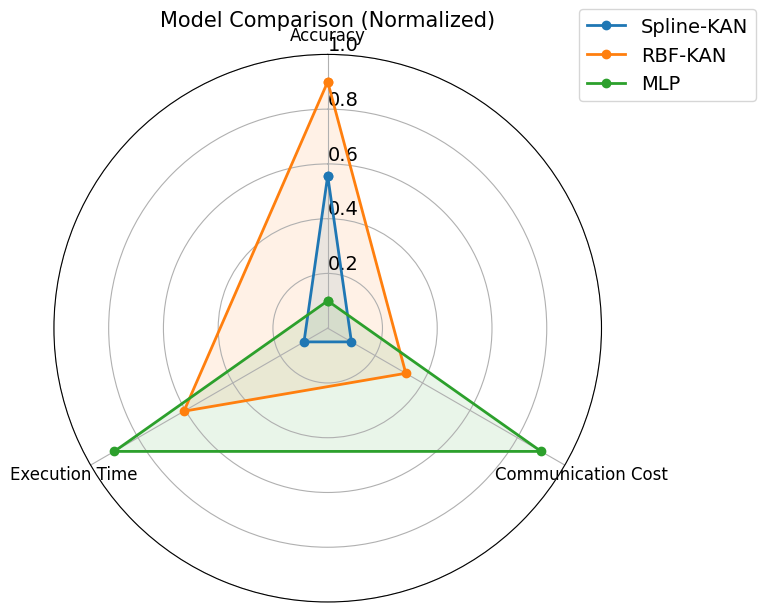

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Raw values (your actual data may differ)
models = ['Spline-KAN', 'RBF-KAN', 'MLP']
accuracy = [0.8267, 0.9213, 0.70078]
comm_cost = [0.6729, 0.5817, 0.3548]  # MB
exec_time = [0.8849, 0.7292, 0.6389]  # sec

# Normalization function
def normalize(arr, inverse=False):
    eps = 1e-8
    norm = (arr - np.min(arr)) / (np.max(arr) - np.min(arr) + eps)
    norm = 0.1 + norm * 0.8  # Map from [0, 1] → [0.1, 0.9]
    return 1 - norm if inverse else norm

# Normalize metrics
normalized_data = np.array([
    normalize(accuracy),                  # Accuracy (higher is better)
    normalize(comm_cost, inverse=True),   # Lower is better
    normalize(exec_time, inverse=True)    # Lower is better
])

# Transpose: rows = models, cols = metrics
data = normalized_data.T

# Radar chart setup
labels = ['Accuracy', 'Communication Cost', 'Execution Time']
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each model
for i, model in enumerate(models):
    values = data[i].tolist()
    values += values[:1]  # close the loop
    ax.plot(angles, values, label=model, marker='o', linewidth=2)
    ax.fill(angles, values, alpha=0.1)

print("Normalized Data:")
for i, model in enumerate(models):
    print(f"{model}: {data[i]}")

# Customize
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)
ax.set_ylim(0, 1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=12)

# Title & Legend
ax.set_title('Model Comparison (Normalized)', size=15, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()


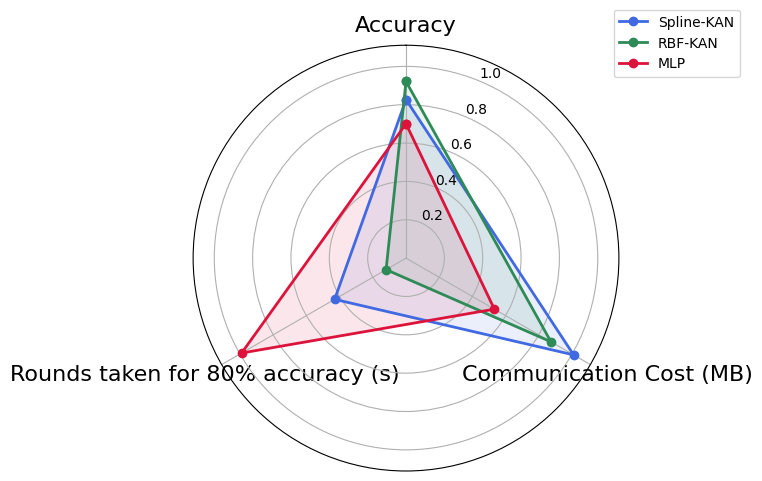

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Raw values
models = ['Spline-KAN', 'RBF-KAN', 'MLP']
accuracy = [0.8267, 0.9213, 0.70078]
comm_cost = [1.0094, 0.8728, 0.5322]  # MB
exec_time = [0.43, 0.12, 0.99]  # sec

# Combine metrics into a matrix (rows = models, columns = metrics)
data = np.array([
    [accuracy[0], comm_cost[0], exec_time[0]],
    [accuracy[1], comm_cost[1], exec_time[1]],
    [accuracy[2], comm_cost[2], exec_time[2]]
])

# Radar chart setup
labels = ['Accuracy', 'Communication Cost (MB)', 'Rounds taken for 80% accuracy (s)']
num_vars = len(labels)

# Calculate angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

# Define custom colors for each model
color_map = {
    'Spline-KAN': 'royalblue',
    'RBF-KAN': 'seagreen',
    'MLP': 'crimson'
}

# Create plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each model
for i, model in enumerate(models):
    values = data[i].tolist()
    values += values[:1]  # close the loop\
    color = color_map[model]
    ax.plot(angles, values, label=model, marker='o', linewidth=2, color=color)
    ax.fill(angles, values, alpha=0.1, color=color)

# Customization
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=16)
ax.set_title('', size=16, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Adjust r-axis scale to accommodate all metrics
max_vals = np.max(data, axis=0)
ax.set_ylim(0, max(max_vals) * 1.1)  # set limit based on largest metric value

plt.tight_layout()
plt.show()


In [ ]:
kan_results[0].

array([0.55549007, 0.59341813, 0.59365109, 0.59282603, 0.59357072,
       0.59522822, 0.60094543, 0.61053208, 0.62684737, 0.6209271 ,
       0.64216442, 0.64103768, 0.66048976, 0.65904502, 0.65976215,
       0.6678501 , 0.66850277, 0.67876462, 0.6646341 , 0.67771203,
       0.67718593, 0.68230132, 0.67185738, 0.69091848, 0.6825634 ,
       0.70716621, 0.68040543, 0.69788357, 0.69761178, 0.68836603,
       0.69023513, 0.71603884, 0.70177515, 0.7157558 , 0.70667777,
       0.72293094, 0.71772158, 0.7160039 , 0.70517363, 0.70924614,
       0.72056834, 0.71760899, 0.73841339, 0.71865614, 0.72847497,
       0.73895619, 0.73206681, 0.72995232, 0.73487979, 0.74620743,
       0.7408847 , 0.73146306, 0.74370351, 0.73822664, 0.73363657,
       0.7438856 , 0.74452274, 0.7473563 , 0.75645801, 0.75315854,
       0.75689792, 0.76108807, 0.75449067, 0.75965732, 0.74695872,
       0.76656688, 0.76128104, 0.76459644, 0.76458867, 0.76350192,
       0.76692564, 0.76980113, 0.77164811, 0.77839848, 0.76297

### Plot all Metrics

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 14,         # base font size
    'axes.titlesize': 20,    # title font size
    'axes.labelsize': 18,    # x and y label size
    'xtick.labelsize': 14,   # x tick label size
    'ytick.labelsize': 14,   # y tick label size
    'legend.fontsize': 14,   # legend font size
})


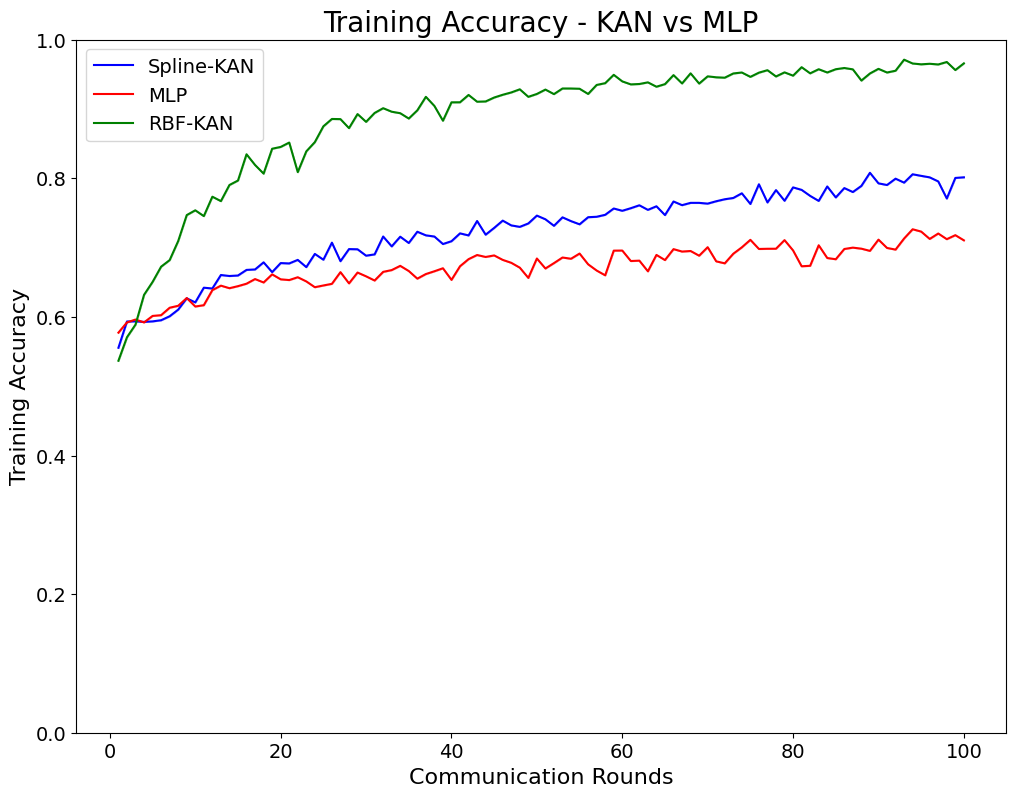

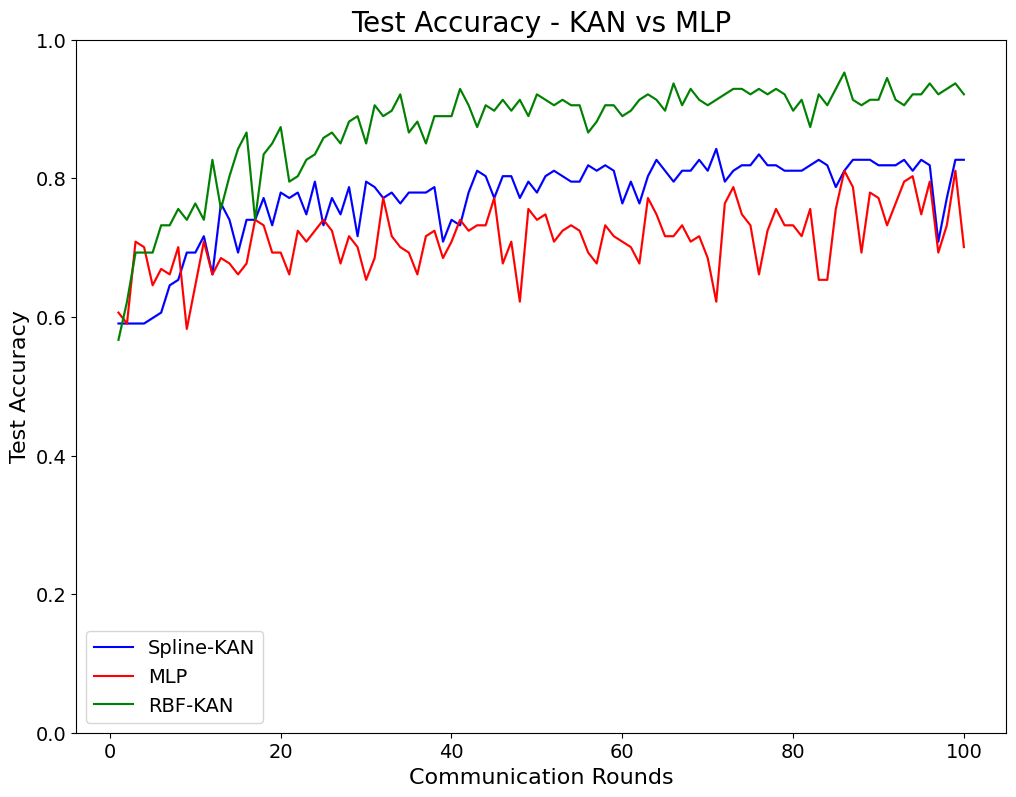

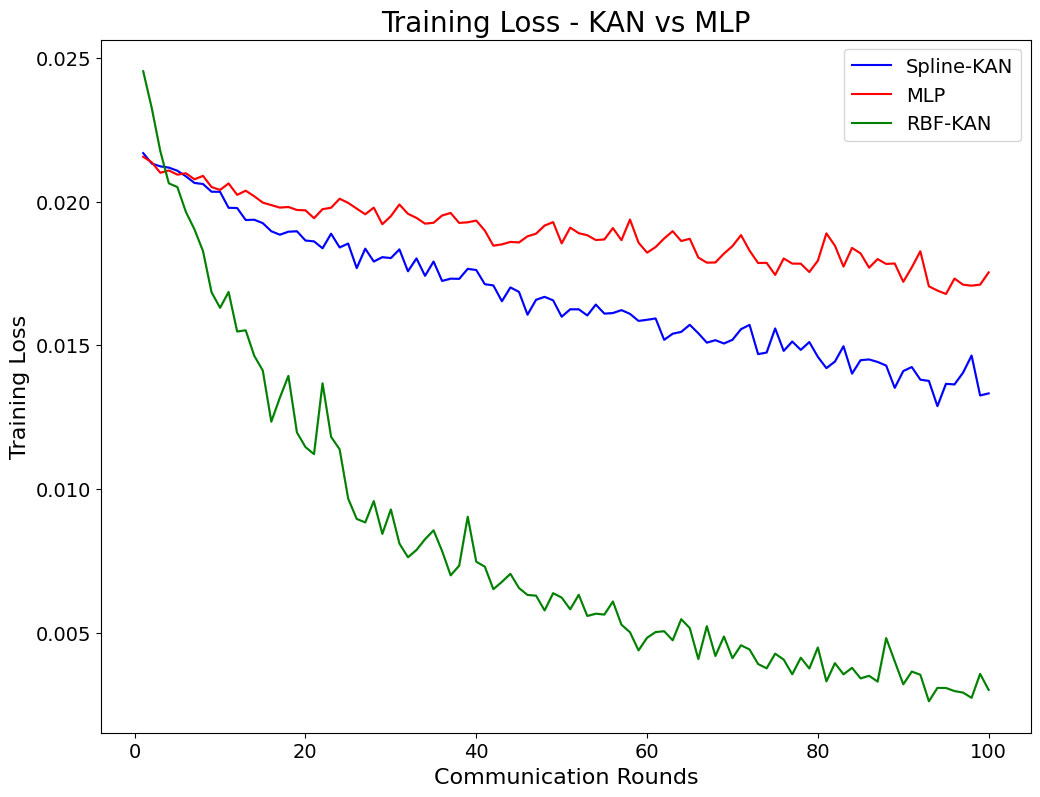

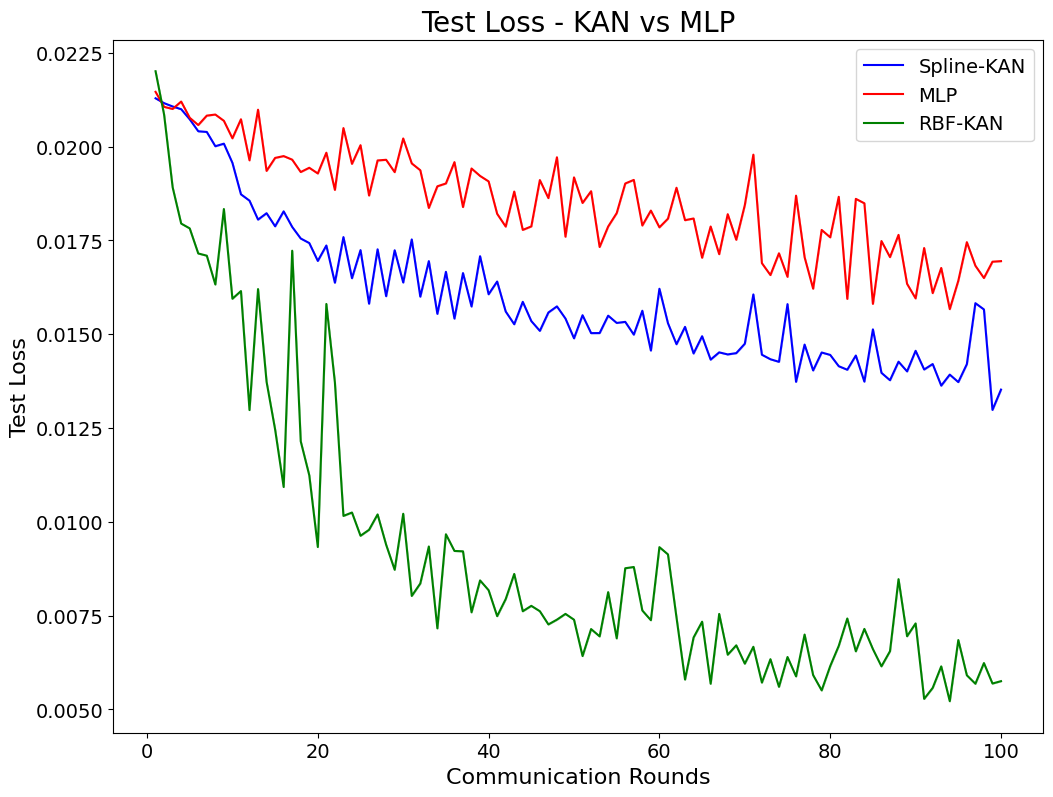

In [ ]:
figsize=(12, 9)

# Plot Training Accuracy with error bands for 'kan' and 'mlp'
plt.figure(figsize=figsize)

plt.plot(comm_rounds, kan_results[0], 'b-', label='Spline-KAN')
plt.fill_between(comm_rounds, kan_results[0] - kan_results[1], kan_results[0] + kan_results[1], color='b', alpha=0.2)

plt.plot(comm_rounds, mlp_results[0], 'r-', label='MLP')
plt.fill_between(comm_rounds, mlp_results[0] - mlp_results[1], mlp_results[0] + mlp_results[1], color='r', alpha=0.2)

plt.plot(comm_rounds, fastkan_results[0], 'g-', label='RBF-KAN')
plt.fill_between(comm_rounds, fastkan_results[0] - fastkan_results[1], fastkan_results[0] + fastkan_results[1], color='g', alpha=0.2)

plt.title(f"Training Accuracy - KAN vs MLP")
plt.xlabel("Communication Rounds")
plt.ylabel("Training Accuracy")
plt.ylim(0, 1)
# plt.xticks(comm_rounds)
plt.legend()
plt.show()

# Plot Test Accuracy with error bands for 'kan' and 'mlp'
plt.figure(figsize=figsize)

plt.plot(comm_rounds, kan_results[2], 'b-', label='Spline-KAN')
plt.fill_between(comm_rounds, kan_results[2] - kan_results[3], kan_results[2] + kan_results[3], color='b', alpha=0.2)

plt.plot(comm_rounds, mlp_results[2], 'r-', label='MLP')
plt.fill_between(comm_rounds, mlp_results[2] - mlp_results[3], mlp_results[2] + mlp_results[3], color='r', alpha=0.2)

plt.plot(comm_rounds, fastkan_results[2], 'g-', label='RBF-KAN')
plt.fill_between(comm_rounds, fastkan_results[2] - fastkan_results[3], fastkan_results[2] + fastkan_results[3], color='g', alpha=0.2)

plt.title(f"Test Accuracy - KAN vs MLP")
plt.xlabel("Communication Rounds")
plt.ylabel("Test Accuracy")
plt.ylim(0, 1)
# plt.xticks(comm_rounds)
plt.legend()
plt.show()

# Plot Training Loss with error bands for 'kan' and 'mlp'
plt.figure(figsize=figsize)

plt.plot(comm_rounds, kan_results[4], 'b-', label='Spline-KAN')
plt.fill_between(comm_rounds, kan_results[4] - kan_results[5], kan_results[4] + kan_results[5], color='b', alpha=0.2)

plt.plot(comm_rounds, mlp_results[4], 'r-', label='MLP')
plt.fill_between(comm_rounds, mlp_results[4] - mlp_results[5], mlp_results[4] + mlp_results[5], color='r', alpha=0.2)

plt.plot(comm_rounds, fastkan_results[4], 'g-', label='RBF-KAN')
plt.fill_between(comm_rounds, fastkan_results[4] - fastkan_results[5], fastkan_results[4] + fastkan_results[5], color='g', alpha=0.2)

plt.title(f"Training Loss - KAN vs MLP")
plt.xlabel("Communication Rounds")
plt.ylabel("Training Loss")
# plt.xticks(comm_rounds)
plt.legend()
plt.show()

# Plot Test Loss with error bands for 'kan' and 'mlp'
plt.figure(figsize=figsize)

plt.plot(comm_rounds, kan_results[6], 'b-', label='Spline-KAN')
plt.fill_between(comm_rounds, kan_results[6] - kan_results[7], kan_results[6] + kan_results[7], color='b', alpha=0.2)

plt.plot(comm_rounds, mlp_results[6], 'r-', label='MLP')
plt.fill_between(comm_rounds, mlp_results[6] - mlp_results[7], mlp_results[6] + mlp_results[7], color='r', alpha=0.2)

plt.plot(comm_rounds, fastkan_results[6], 'g-', label='RBF-KAN')
plt.fill_between(comm_rounds, fastkan_results[6] - fastkan_results[7], fastkan_results[6] + fastkan_results[7], color='g', alpha=0.2)

plt.title(f"Test Loss - KAN vs MLP")
plt.xlabel("Communication Rounds")
plt.ylabel("Test Loss")
# plt.xticks(comm_rounds)
plt.legend()
plt.show()

#Communication Cost per Round (MLP vs KAN)

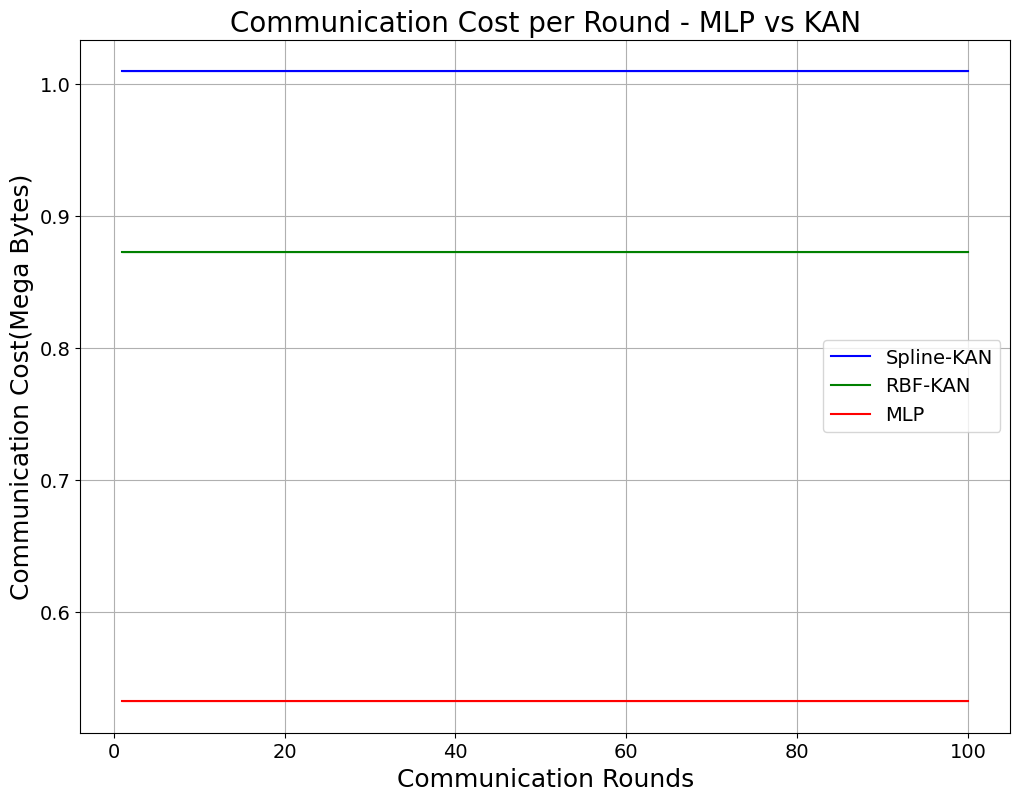

In [ ]:
plt.figure(figsize=figsize)

# Plot for Spline-KAN
plt.plot(comm_rounds, kan_results[10], 'b-', label='Spline-KAN')
plt.fill_between(comm_rounds, kan_results[10] - kan_results[11], kan_results[10] + kan_results[11], color='b', alpha=0.2)

# Plot for Spline-KAN
plt.plot(comm_rounds, fastkan_results[10], 'g-', label='RBF-KAN')
plt.fill_between(comm_rounds, fastkan_results[10] - fastkan_results[11], fastkan_results[10] + fastkan_results[11], color='g', alpha=0.2)

# Plot for MLP
plt.plot(comm_rounds, mlp_results[10], 'r-', label='MLP')
plt.fill_between(comm_rounds, mlp_results[10] - mlp_results[11], mlp_results[10] + mlp_results[11], color='r', alpha=0.2)

plt.title("Communication Cost per Round - MLP vs KAN")
plt.xlabel("Communication Rounds")
plt.ylabel("Communication Cost(Mega Bytes)")
plt.legend()
plt.grid(True)
plt.show()

#KAN: Accuracy vs Communication Rounds

In [ ]:
plt.figure(figsize=figsize)
plt.plot(comm_rounds, kan_results[0], 'b-', label='Train Accuracy')
plt.fill_between(comm_rounds, kan_results[0] - kan_results[1], kan_results[0] + kan_results[1], color='b', alpha=0.2)

plt.plot(comm_rounds, kan_results[2], 'c-', label='Test Accuracy')
plt.fill_between(comm_rounds, kan_results[2] - kan_results[3], kan_results[2] + kan_results[3], color='c', alpha=0.2)

plt.title("Spline-KAN: Accuracy vs Communication Rounds")
plt.xlabel("Communication Rounds")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.show()

#MLP: Accuracy vs Communication Rounds

In [ ]:
plt.figure(figsize=figsize)
plt.plot(comm_rounds, mlp_results[0], 'r-', label='Train Accuracy')
plt.fill_between(comm_rounds, mlp_results[0] - mlp_results[1], mlp_results[0] + mlp_results[1], color='r', alpha=0.2)

plt.plot(comm_rounds, mlp_results[2], 'm-', label='Test Accuracy')
plt.fill_between(comm_rounds, mlp_results[2] - mlp_results[3], mlp_results[2] + mlp_results[3], color='m', alpha=0.2)

plt.title("MLP: Accuracy vs Communication Rounds")
plt.xlabel("Communication Rounds")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.show()

#KAN: Loss vs Communication Rounds

In [ ]:
plt.figure(figsize=figsize)
plt.plot(comm_rounds, kan_results[4], 'b-', label='Train Loss')
plt.fill_between(comm_rounds, kan_results[4] - kan_results[5], kan_results[4] + kan_results[5], color='b', alpha=0.2)

plt.plot(comm_rounds, kan_results[6], 'c-', label='Test Loss')
plt.fill_between(comm_rounds, kan_results[6] - kan_results[7], kan_results[6] + kan_results[7], color='c', alpha=0.2)

plt.title("Spline-KAN: Loss vs Communication Rounds")
plt.xlabel("Communication Rounds")
plt.ylabel("Loss")
plt.legend()
plt.show()

#MLP: Loss vs Communication Rounds

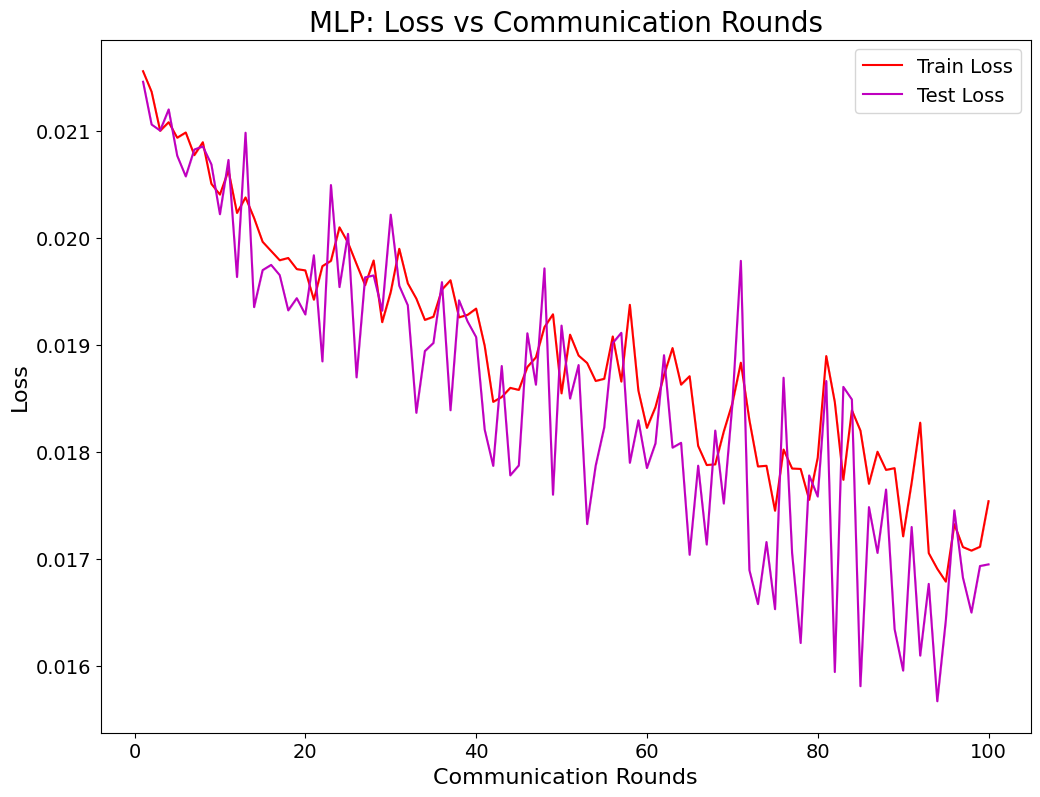

In [ ]:
plt.figure(figsize=figsize)
plt.plot(comm_rounds, mlp_results[4], 'r-', label='Train Loss')
plt.fill_between(comm_rounds, mlp_results[4] - mlp_results[5], mlp_results[4] + mlp_results[5], color='r', alpha=0.2)

plt.plot(comm_rounds, mlp_results[6], 'm-', label='Test Loss')
plt.fill_between(comm_rounds, mlp_results[6] - mlp_results[7], mlp_results[6] + mlp_results[7], color='m', alpha=0.2)

plt.title("MLP: Loss vs Communication Rounds")
plt.xlabel("Communication Rounds")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
print(f"Execution time for KAN: {kan_results[8]} ± {kan_results[9]} seconds")
print(f"Execution time for MLP: {mlp_results[8]} ± {mlp_results[9]} seconds")
print(f"Execution time for FastKAN: {fastkan_results[8]} ± {fastkan_results[9]} seconds")


## Hypothesis Testing

### Convert to Pandas Dataframe and Process Data

In [ ]:
import pandas as pd
df_kan = pd.DataFrame(kan_data)
df_mlp = pd.DataFrame(mlp_data)
df_fastkan = pd.DataFrame(fastkan_data)

In [ ]:
# Function to process the dataframe as described by the user
def process_dataframe(df):
    # Step 1: Remove the columns 'train_accuracy', 'test_loss', 'train_loss'
    df = df.drop(columns=['train_accuracy', 'test_loss', 'train_loss'])

    # Step 2: Modify the 'test_accuracy' column
    # Removing the first pair (round 0) and keeping only the accuracy value from remaining pairs
    df['test_accuracy'] = df['test_accuracy'].apply(lambda x: [pair[0] for pair in x[1:]])

    # Step 3: Create new columns r10, r20, r30, ..., r100
    for i in range(1, 11):
        df[f'r{i*10}'] = df['test_accuracy'].apply(lambda x: x[i*10-1])

    return df

processed_kan_data = process_dataframe(df_kan)
processed_mlp_data = process_dataframe(df_mlp)
processed_fastkan_data = process_dataframe(df_fastkan)

In [ ]:
processed_kan_data.head(3)

### Get Accuracy Means for Selected Rounds

In [ ]:
rounds = [f'r{i*10}' for i in range(1, 11)]

#### Spline-KAN Accuracy Means

In [ ]:
processed_kan_data[rounds].describe().round(3).T

#### RBF-KAN Accuracy Means

In [ ]:
processed_fastkan_data[rounds].describe().round(3).T

#### MLP Accuracy Means

In [ ]:
processed_mlp_data[rounds].describe().round(3).T

Difference between Accuracy Means for Spline-KAN vs MLP

In [ ]:
(processed_kan_data[rounds].mean() - processed_mlp_data[rounds].mean()).round(3)

### Apply tests for accuracy

In [ ]:
from scipy.stats import ttest_ind

# Function to apply Welch's t-test
def welchs_ttest(kan_data, mlp_data, round_column):
    # Perform one-sided Welch's t-test (greater test)
    t_stat, p_value = ttest_ind(kan_data[round_column],
                                mlp_data[round_column],
                                equal_var=False,
                                alternative='greater'
                                )

    return t_stat, p_value

# List of rounds (columns)
rounds = [f'r{i*10}' for i in range(1, 11)]

# Dictionary to store t-statistics and p-values for each round
kan_mlp_results = {}
fastkan_mlp_results = {}

# Apply Welch's t-test for both comparisons
for round_col in rounds:
    kan_mlp_t_stat, kan_mlp_p_value = welchs_ttest(processed_kan_data, processed_mlp_data, round_col)
    kan_mlp_results[round_col] = {'t_stat': kan_mlp_t_stat, 'p_value': kan_mlp_p_value}
    fastkan_mlp_t_stat, fastkan_mlp_p_value = welchs_ttest(processed_fastkan_data, processed_mlp_data, round_col)
    fastkan_mlp_results[round_col] = {'t_stat': fastkan_mlp_t_stat, 'p_value': fastkan_mlp_p_value}

# Displaying the results
kan_mlp_results_df = pd.DataFrame(kan_mlp_results).T
fastkan_mlp_results_df = pd.DataFrame(fastkan_mlp_results).T

# Suppress scientific notation and set precision to 10 decimal places
#pd.set_option('display.float_format', lambda x: f'{x:.10f}')
#pd.reset_option('display.float_format')

print("KAN vs MLP:")
display(kan_mlp_results_df.round(4))
print("\nFastKAN vs MLP:")
display(fastkan_mlp_results_df.round(4))

## Find ratio between execution times

In [ ]:
from scipy import stats

def times_ratio(sample_A, sample_B):
        mean_A = np.mean(sample_A)
        mean_B = np.mean(sample_B)
        return mean_A / mean_B

def calculate_confidence_interval(df_kan, df_mlp, confidence_level=0.95, n_resamples=10000):

    # Perform bootstrap
    res = stats.bootstrap(
        data=(df_kan['execution_time'], df_mlp['execution_time']),
        statistic=times_ratio,
        confidence_level=confidence_level,
        n_resamples=n_resamples,
        method='percentile',
        vectorized=False,
        paired=False,
        random_state=42
    )

    lower_bound = res.confidence_interval.low
    upper_bound = res.confidence_interval.high

    return lower_bound, upper_bound

### Spline-KAN vs MLP

In [ ]:
lower_bound, upper_bound = calculate_confidence_interval(df_kan, df_mlp, confidence_level=0.95)

print(f"{int(confidence_level*100)}% Confidence Interval for beta: ({lower_bound:.2f}, {upper_bound:.2f})")

### RBF-KAN vs MLP

In [ ]:
lower_bound, upper_bound = calculate_confidence_interval(df_fastkan, df_mlp, confidence_level=0.95)

print(f"{int(confidence_level*100)}% Confidence Interval for beta: ({lower_bound:.2f}, {upper_bound:.2f})")

# Estimate Parameters from Zeydan et al. [2024] - [ArXiv](https://arxiv.org/pdf/2407.20100)

We are adapting the authors code from GitHub (https://github.com/ezeydan/F-KANs/blob/main/main.py)

In [ ]:
!pip install pykan

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from kan import KAN as PyKAN
import matplotlib.pyplot as plt
import copy
import time


# Split train_dataset for federated learning into 2 clients
num_clients = 2
rounds = 20

# Define the KANClassifier with Dropout layers
class KANClassifier(nn.Module):
    def __init__(self, kan_model, num_classes):
        super(KANClassifier, self).__init__()
        self.kan_model = kan_model
        last_layer_width = kan_model.width[-1]
        if isinstance(last_layer_width, list):
            if len(last_layer_width) == 2:
                last_layer_width = last_layer_width[0]
            else:
                raise ValueError("Unexpected format for kan_model.width[-1]")
        self.fc = nn.Linear(last_layer_width, num_classes)
        self.dropout = nn.Dropout(p=0.5)  # Dropout with 50% probability
        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.kaiming_normal_(self.fc.weight)
        if self.fc.bias is not None:
            nn.init.constant_(self.fc.bias, 0)

    def forward(self, x):
        x = self.kan_model(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

    def train_kan(self, dataset, steps, lamb, lamb_entropy):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight decay
        loss_fn = nn.CrossEntropyLoss()
        for step in range(steps):
            optimizer.zero_grad()
            outputs = self(dataset['train_input'].float())
            loss = loss_fn(outputs, dataset['train_label'])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
            optimizer.step()

# Define the MLP model with the same depth as KAN
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < len(sizes) - 2:
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(p=0.5))  # Dropout with 50% probability
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def train_model(self, dataset, steps, learning_rate=0.001):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-5)  # Added weight decay
        loss_fn = nn.CrossEntropyLoss()
        for step in range(steps):
            optimizer.zero_grad()
            outputs = self(dataset['train_input'].float())
            loss = loss_fn(outputs, dataset['train_label'])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
            optimizer.step()

def create_dataset(loader):
    inputs = []
    labels = []
    for data in loader:
        inputs.append(data[0])
        labels.append(data[1])
    inputs = torch.cat(inputs, dim=0)
    labels = torch.cat(labels, dim=0)
    return {
        'train_input': inputs,
        'train_label': labels,
        'test_input': inputs.clone(),
        'test_label': labels.clone()
    }

def fed_avg(global_model, client_models):
    global_state_dict = global_model.state_dict()
    for param_tensor in global_state_dict:
        global_state_dict[param_tensor].zero_()
    for client_model in client_models:
        client_state_dict = client_model.state_dict()
        for param_tensor in global_state_dict:
            global_state_dict[param_tensor] += client_state_dict[param_tensor] / len(client_models)
    global_model.load_state_dict(global_state_dict)
    return global_model

def compute_metrics(model, loader):
    loss_fn = torch.nn.CrossEntropyLoss()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    model.training = False
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs.float())
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    model.training = True
    return avg_loss, accuracy, precision, recall, f1

def federated_learning_rounds(global_model, client_loaders, test_loader, rounds=rounds, steps=20):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    train_precisions = []
    test_precisions = []
    train_recalls = []
    test_recalls = []
    train_f1s = []
    test_f1s = []

    for round_num in range(rounds):
        client_models = [copy.deepcopy(global_model) for _ in range(len(client_loaders))]
        for i, client_loader in enumerate(client_loaders):
            client_dataset = create_dataset(client_loader)
            print(f"Training client {i+1}/{len(client_loaders)}")
            if isinstance(client_models[i], KANClassifier):
                client_models[i].train_kan(client_dataset, steps, lamb=0.01, lamb_entropy=10.0)
            elif isinstance(client_models[i], MLP):
                client_models[i].train_model(client_dataset, steps)

        global_model = fed_avg(global_model, client_models)

        train_loss, train_accuracy, train_precision, train_recall, train_f1 = compute_metrics(global_model, client_loaders[0])
        test_loss, test_accuracy, test_precision, test_recall, test_f1 = compute_metrics(global_model, test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        train_precisions.append(train_precision)
        test_precisions.append(test_precision)
        train_recalls.append(train_recall)
        test_recalls.append(test_recall)
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)

        print(f'Round {round_num+1} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, '
              f'Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}, '
              f'Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}, '
              f'Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}')

    return global_model, train_losses, test_losses, train_accuracies, test_accuracies, train_precisions, test_precisions, train_recalls, test_recalls, train_f1s, test_f1s

# Initialize KAN model with 3 hidden layers and dropout
kan_width = [4, 20, 20, 20]
base_kan_model = PyKAN(width=kan_width, grid=5, k=3, seed=0)
last_layer_width = base_kan_model.width[-1]
if isinstance(last_layer_width, list):
    if len(last_layer_width) == 2:
        last_layer_width = last_layer_width[0]
    else:
        raise ValueError("Unexpected format for kan_model.width[-1]")
kan_global_model = KANClassifier(base_kan_model, num_classes=3)

# Initialize MLP model with 3 hidden layers and the same number of units as KAN
input_size = 4
hidden_sizes = [20, 20, 20]
output_size = 3
mlp_model = MLP(input_size, hidden_sizes, output_size)

## PyKAN Parameters

In [ ]:
kan_params = sum(p.numel() for p in kan_global_model.parameters() if p.requires_grad)
print(f"Total KAN Parameters: {kan_params}")

In [ ]:
mlp_params = sum(p.numel() for p in mlp_model.parameters() if p.requires_grad)
print(f"Total MLP Parameters: {mlp_params}")